In [ ]:
#%pip install numpy matplotlib h5py scipy tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow import keras

# Clases y funciones

## Función de carga de datos

In [ ]:
from pathlib import Path
import os
import csv
import numpy as np
from PIL import Image

def load_dataset(
    csv_path='/content/drive/MyDrive/archive/flower_images/flower_images/flower_labels.csv',
    images_dir='/content/drive/MyDrive/archive/flower_images/flower_images',
    img_size=(64, 64),
    test_size=0.2,
    seed=42,
    normalize=True,
    ):
    """Load images and labels from a CSV file.

    CSV format: file,label
    - file: image filename (e.g., 0001.png)
    - label: integer class id

    Returns:
        train_set_x_orig: (m_train, H, W, 3) float32
        train_set_y_orig: (1, m_train) int64
        test_set_x_orig: (m_test, H, W, 3) float32
        test_set_y_orig: (1, m_test) int64
        classes: (num_classes,) array of class names (strings)
    """
    csv_path = Path(csv_path)
    images_dir = Path(images_dir)

    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found: {csv_path.resolve()}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir.resolve()}")

    files = []
    labels = []
    with csv_path.open('r', newline='') as f:
        reader = csv.DictReader(f)
        if 'file' not in reader.fieldnames or 'label' not in reader.fieldnames:
            raise ValueError(f"CSV must have columns 'file' and 'label'. Found: {reader.fieldnames}")
        for row in reader:
            files.append(row['file'])
            labels.append(int(row['label']))

    labels = np.array(labels, dtype=np.int64)
    max_label = int(labels.max()) if labels.size else -1
    classes = np.array([str(i) for i in range(max_label + 1)])

    # Load images
    X = []
    y = []
    for fname, label in zip(files, labels):
        img_path = images_dir / fname
        if not img_path.is_file():
            # Skip missing files silently (or raise if you prefer)
            continue
        img = Image.open(img_path)
        img = img.resize(img_size)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        X.append(np.array(img, dtype=np.float32))
        y.append(label)

    if len(X) == 0:
        raise ValueError("No images were loaded. Check paths and CSV content.")

    X = np.stack(X, axis=0)  # (m, H, W, 3)
    y = np.array(y, dtype=np.int64)
    if normalize:
        X = X / 255.0

    # Stratified split train/test
    rng = np.random.default_rng(seed)
    train_idx = []
    test_idx = []
    for lbl in np.unique(y):
        idx = np.where(y == lbl)[0]
        rng.shuffle(idx)
        n = idx.size
        if n <= 1:
            train_idx.extend(idx.tolist())
            continue
        n_test = int(round(n * test_size))
        n_test = max(1, min(n - 1, n_test))
        test_idx.extend(idx[:n_test].tolist())
        train_idx.extend(idx[n_test:].tolist())

    train_idx = np.array(train_idx, dtype=np.int64)
    test_idx = np.array(test_idx, dtype=np.int64)
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)

    train_set_x_orig = X[train_idx]
    train_set_y_orig = y[train_idx].reshape(1, -1)
    test_set_x_orig = X[test_idx]
    test_set_y_orig = y[test_idx].reshape(1, -1)

    print(f"Training set: {train_set_x_orig.shape}, {train_set_y_orig.shape}")
    print(f"Test set: {test_set_x_orig.shape}, {test_set_y_orig.shape}")
    print(f"Classes: {classes}")

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Implementación del modelo

### Función de activación

In [ ]:
# GRADED FUNCTION: sigmoid
from typing import Any, Dict, List, Tuple, Union, TypedDict

class Grads(TypedDict):
    dw: np.ndarray
    db: float

class Params(TypedDict):
    w: np.ndarray
    b: float

def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Compute the sigmoid of z (implementación estable numéricamente).

    Nota: retorna `float64` para arrays para mejorar estabilidad numérica.

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    z_arr = np.asarray(z)
    z64 = z_arr.astype(np.float64, copy=False)
    out = np.empty_like(z64, dtype=np.float64)
    pos = z64 >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z64[pos]))
    exp_z = np.exp(z64[~pos])
    out[~pos] = exp_z / (1.0 + exp_z)
    if np.isscalar(z):
        return float(out)
    return out

### Función de inicialización

In [ ]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim: int) -> Tuple[np.ndarray, float]:
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

### Función de propagación

In [ ]:
# GRADED FUNCTION: propagate

def propagate(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray, lambda_: float = 0.0) -> Tuple[Grads, float]:
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    lambda_ -- L2 regularization strength (0.0 disables regularization)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    Z = np.dot(w.T, X) + b  # (1, m)
    A = sigmoid(Z)          # (1, m)
    # Costo estable numéricamente: evita log(0) aunque A sature a 0/1
    # + regularización L2: (lambda_/(2m)) * ||w||^2
    cost = (1.0 / m) * np.sum(np.logaddexp(0.0, Z) - Y * Z) + (lambda_ / (2.0 * m)) * np.sum(w * w)
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T) + (lambda_ / m) * w
    db = float((1 / m) * np.sum(A - Y))
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(isinstance(db, float))
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads: Grads = {"dw": dw,
             "db": db}

    return grads, float(cost)

### Función de optimización

In [ ]:
# GRADED FUNCTION: optimize

def optimize(
    w: np.ndarray,
    b: float,
    X: np.ndarray,
    Y: np.ndarray,
    num_iterations: int,
    learning_rate: float,
    print_cost: bool = False,
    lambda_: float = 0.0,
) -> Tuple[Params, Grads, List[float]]:
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    lambda_ -- L2 regularization strength (0.0 disables regularization)

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs: List[float] = []

    for i in range(num_iterations):

        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y, lambda_=lambda_)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(float(cost))

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params: Params = {"w": w,
              "b": float(b)}

    grads_out: Grads = {"dw": dw,
             "db": float(db)}

    return params, grads_out, costs

### Función de predicción

In [ ]:
# GRADED FUNCTION: predict

def predict(w: np.ndarray, b: float, X: np.ndarray) -> np.ndarray:
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

### Construcción del modelo

In [ ]:
# GRADED FUNCTION: model

def model(
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    num_iterations: int = 2000,
    learning_rate: float = 0.5,
    lambda_: float = 0.0,
    print_cost: bool = False,
 ) -> Dict[str, Any]:
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    lambda_ -- L2 regularization strength (0.0 disables regularization)
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(
        w,
        b,
        X_train,
        Y_train,
        num_iterations=num_iterations,
        learning_rate=learning_rate,
        print_cost=print_cost,
        lambda_=lambda_,
    )

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d: Dict[str, Any] = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "lambda_": float(lambda_),
         "num_iterations": num_iterations}

    return d

### Versión multiclase: Softmax (implementación propia)

> Esta sección implementa **regresión logística multiclase** (Softmax) desde cero.
- A diferencia de One-vs-Rest, aquí se entrena **un solo modelo** con $K$ salidas.
- Se usa una pérdida estable numéricamente (log-sum-exp) y soporta regularización L2 con `lambda_`.

In [ ]:
# Implementación propia: Softmax Regression (multiclase)
from typing import Optional
from typing import TypedDict

class SoftmaxGrads(TypedDict):
    dW: np.ndarray
    db: np.ndarray

class SoftmaxParams(TypedDict):
    W: np.ndarray
    b: np.ndarray

def one_hot(Y: np.ndarray, num_classes: int) -> np.ndarray:
    """
    Y: (1, m) con enteros 0..K-1 -> retorna (K, m)
    """
    Y_int = Y.astype(int).reshape(-1)
    m = Y_int.size
    out = np.zeros((num_classes, m), dtype=np.float64)
    out[Y_int, np.arange(m)] = 1.0
    return out

def softmax(Z: np.ndarray) -> np.ndarray:
    """
    Softmax estable numéricamente.
    Z: (K, m) -> retorna P: (K, m) con sum_k P[k,i] = 1
    """
    Z64 = Z.astype(np.float64, copy=False)
    Z_shift = Z64 - np.max(Z64, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shift)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def initialize_softmax(num_classes: int, n_features: int) -> SoftmaxParams:
    W = np.zeros((num_classes, n_features), dtype=np.float64)
    b = np.zeros((num_classes, 1), dtype=np.float64)
    return {"W": W, "b": b}

def propagate_softmax(
    W: np.ndarray,
    b: np.ndarray,
    X: np.ndarray,
    Y_int: np.ndarray,
    lambda_: float = 0.0,
 ) -> tuple[SoftmaxGrads, float]:
    """
    X: (n_features, m)
    Y_int: (1, m) con enteros 0..K-1
    W: (K, n_features)
    b: (K, 1)

    Retorna grads y costo (cross-entropy + L2).
    """
    m = X.shape[1]
    K = W.shape[0]

    Z = (W @ X) + b  # (K, m)
    # Costo estable con log-sum-exp
    Z64 = Z.astype(np.float64, copy=False)
    Z_shift = Z64 - np.max(Z64, axis=0, keepdims=True)
    logsumexp = np.log(np.sum(np.exp(Z_shift), axis=0, keepdims=True))  # (1, m)
    log_probs = Z_shift - logsumexp  # (K, m)

    Y_oh = one_hot(Y_int, K)  # (K, m)
    data_loss = -(1.0 / m) * np.sum(Y_oh * log_probs)
    reg_loss = (lambda_ / (2.0 * m)) * np.sum(W * W)
    cost = float(data_loss + reg_loss)

    P = np.exp(log_probs)  # (K, m)
    dZ = (P - Y_oh)  # (K, m)
    dW = (1.0 / m) * (dZ @ X.T) + (lambda_ / m) * W
    db = (1.0 / m) * np.sum(dZ, axis=1, keepdims=True)

    grads: SoftmaxGrads = {"dW": dW, "db": db}
    return grads, cost

def optimize_softmax(
    X: np.ndarray,
    Y_int: np.ndarray,
    num_classes: int,
    num_iterations: int = 2000,
    learning_rate: float = 0.05,
    lambda_: float = 0.0,
    print_cost: bool = False,
 ) -> tuple[SoftmaxParams, list[float]]:
    n_features = X.shape[0]
    params = initialize_softmax(num_classes, n_features)
    W = params["W"]
    b = params["b"]

    costs: list[float] = []
    for i in range(num_iterations):
        grads, cost = propagate_softmax(W, b, X, Y_int, lambda_=lambda_)
        W = W - learning_rate * grads["dW"]
        b = b - learning_rate * grads["db"]

        if i % 100 == 0:
            costs.append(float(cost))
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.6f}")

    return {"W": W, "b": b}, costs

def predict_softmax(W: np.ndarray, b: np.ndarray, X: np.ndarray) -> np.ndarray:
    Z = (W @ X) + b  # (K, m)
    P = softmax(Z)
    return np.argmax(P, axis=0).reshape(1, -1)

# Carga de datos y entrenamientos

In [ ]:
# Load data from Google Drive (only if running in Google Colab)

try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception as e:
    print("Not running in Colab; skipping Drive mount.")

Mounted at /content/drive


In [ ]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset(
    csv_path='/content/drive/MyDrive/archive/flower_images/flower_images/flower_labels.csv',
    images_dir='/content/drive/MyDrive/archive/flower_images/flower_images'
)

Training set: (168, 64, 64, 3), (1, 168)
Test set: (42, 64, 64, 3), (1, 42)
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


y = [5], it's a '5' picture.


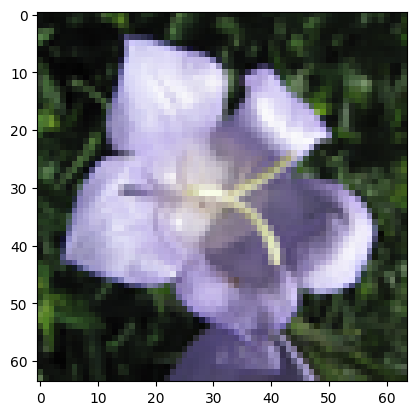

In [ ]:
index = 0
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[int(np.squeeze(train_set_y[:,index]))] +  "' picture.")

In [ ]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 168
Number of testing examples: m_test = 42
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (168, 64, 64, 3)
train_set_y shape: (1, 168)
test_set_x shape: (42, 64, 64, 3)
test_set_y shape: (1, 42)


In [ ]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 168)
train_set_y shape: (1, 168)
test_set_x_flatten shape: (12288, 42)
test_set_y shape: (1, 42)
sanity check after reshaping: [0.05882353 0.07450981 0.0627451  0.04313726 0.05098039]


Clase 0: último costo = 0.019764341202428384
Clase 1: último costo = 0.014860754720501728
Clase 2: último costo = 0.009277130281423457
Clase 3: último costo = 0.019592920743508237
Clase 4: último costo = 0.007575607091737091
Clase 5: último costo = 0.022764158488574042
Clase 6: último costo = 0.016179409527230848
Clase 7: último costo = 0.008867042804242884
Clase 8: último costo = 0.016061539967628297
Clase 9: último costo = 0.019092424388778537
Train accuracy (OVR + sigmoid): 100.00%
Test accuracy  (OVR + sigmoid): 35.71%


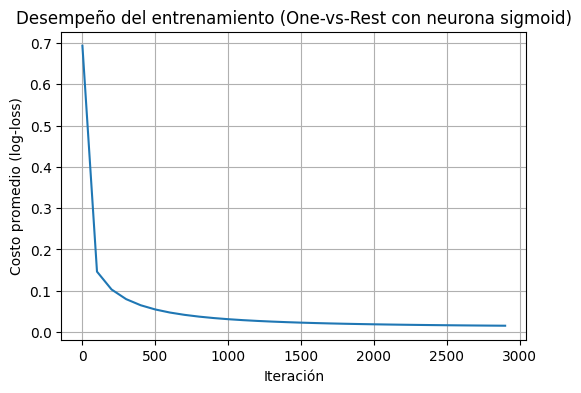

In [ ]:
# === Entrenamiento multiclase usando la neurona (sigmoid) existente: One-vs-Rest ===

# Requiere que ya hayas ejecutado las celdas de "Implementación del modelo" (sigmoid, initialize_with_zeros, propagate, optimize).
required_fns = ["sigmoid", "initialize_with_zeros", "propagate", "optimize"]
missing = [fn for fn in required_fns if fn not in globals()]
if missing:
    raise RuntimeError(f"Faltan funciones: {missing}. Ejecuta primero las celdas de implementación del modelo.")

# Datos (features ya aplanadas) -> X: (n_features, m), Y: (1, m) con clases 0..K-1
X_train = train_set_x_flatten.astype(np.float32)
X_test = test_set_x_flatten.astype(np.float32)
Y_train_int = train_set_y.astype(int)
Y_test_int = test_set_y.astype(int)

K = int(np.max(np.concatenate([Y_train_int, Y_test_int], axis=1))) + 1
n_features = X_train.shape[0]

def train_one_vs_rest(
    X: np.ndarray,
    Y: np.ndarray,
    num_classes: int,
    num_iterations: int = 2000,
    learning_rate: float = 0.005,
    print_cost: bool = False,
    lambda_: float = 1.0,
 ):
    """
    Entrena num_classes clasificadores binarios (clase k vs resto) usando optimize().

    Regularización:
      - Se usa L2 (weight decay) con parámetro lambda_.
      - Si lambda_=0.0, queda igual que la versión sin regularización.

    Returns:
      W: (n_features, K)
      b: (K, 1)
      costs_per_class: lista de listas (cada una con costos cada 100 iters)
    """
    W = np.zeros((X.shape[0], num_classes), dtype=np.float32)
    b = np.zeros((num_classes, 1), dtype=np.float32)
    costs_per_class = []

    for k in range(num_classes):
        Yk = (Y == k).astype(int)  # (1, m) binario
        wk, bk = initialize_with_zeros(X.shape[0])
        params, grads, costs = optimize(
            wk,
            float(bk),
            X,
            Yk,
            num_iterations=num_iterations,
            learning_rate=learning_rate,
            print_cost=False,
            lambda_=lambda_,
        )
        W[:, k:k+1] = params["w"].astype(np.float32)
        b[k, 0] = float(params["b"])
        costs_per_class.append(costs)
        if print_cost:
            print(f"Clase {k}: último costo = {costs[-1] if len(costs) else None}")

    return W, b, costs_per_class

def predict_one_vs_rest(W: np.ndarray, b: np.ndarray, X: np.ndarray) -> np.ndarray:
    """
    W: (n_features, K), b: (K,1), X: (n_features, m)
    Return: y_pred (1, m) por argmax de probabilidades sigmoid
    """
    Z = (W.T @ X) + b  # (K, m)
    P = sigmoid(Z)      # (K, m) probas por clasificador
    return np.argmax(P, axis=0).reshape(1, -1)

# Entrenar OVR con la neurona existente
# Notas:
# - learning_rate más bajo para que sea menos agresivo
# - lambda_ agrega regularización L2 para reducir sobreajuste
W_ovr, b_ovr, costs_per_class = train_one_vs_rest(
    X_train, Y_train_int, K, num_iterations=3000, learning_rate=0.005, print_cost=True, lambda_=1.0
)

# Evaluación
Y_pred_train = predict_one_vs_rest(W_ovr, b_ovr, X_train)
Y_pred_test = predict_one_vs_rest(W_ovr, b_ovr, X_test)

train_acc = 100.0 * np.mean(Y_pred_train == Y_train_int)
test_acc = 100.0 * np.mean(Y_pred_test == Y_test_int)
print(f"Train accuracy (OVR + sigmoid): {train_acc:.2f}%")
print(f"Test accuracy  (OVR + sigmoid): {test_acc:.2f}%")

# Curva de desempeño: costo promedio entre clases (cada 100 iteraciones)
min_len = min(len(c) for c in costs_per_class) if costs_per_class else 0
if min_len > 0:
    costs_avg = np.mean(np.array([c[:min_len] for c in costs_per_class], dtype=np.float32), axis=0)
    xs = np.arange(min_len) * 100
    plt.figure(figsize=(6, 4))
    plt.plot(xs, costs_avg)
    plt.xlabel('Iteración')
    plt.ylabel('Costo promedio (log-loss)')
    plt.title('Desempeño del entrenamiento (One-vs-Rest con neurona sigmoid)')
    plt.grid(True)
    plt.show()
else:
    print("No hay suficientes puntos de costo para plottear.")

Cost after iteration 0: 2.302585
Cost after iteration 100: 0.059370
Cost after iteration 200: 0.050446
Cost after iteration 300: 0.047800
Cost after iteration 400: 0.046312
Cost after iteration 500: 0.045293
Cost after iteration 600: 0.044524
Cost after iteration 700: 0.043910
Cost after iteration 800: 0.043404
Cost after iteration 900: 0.042979
Cost after iteration 1000: 0.042617
Cost after iteration 1100: 0.042307
Cost after iteration 1200: 0.042040
Cost after iteration 1300: 0.041808
Cost after iteration 1400: 0.041608
Cost after iteration 1500: 0.041434
Cost after iteration 1600: 0.041283
Cost after iteration 1700: 0.041150
Cost after iteration 1800: 0.041035
Cost after iteration 1900: 0.040935
Cost after iteration 2000: 0.040846
Cost after iteration 2100: 0.040769
Cost after iteration 2200: 0.040701
Cost after iteration 2300: 0.040642
Cost after iteration 2400: 0.040589
Cost after iteration 2500: 0.040542
Cost after iteration 2600: 0.040501
Cost after iteration 2700: 0.040465
Cost

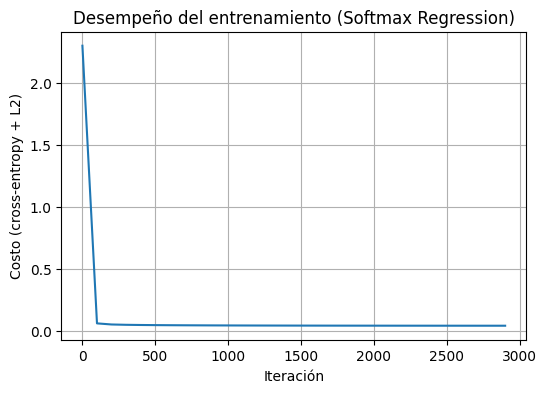

In [ ]:
# === Entrenamiento multiclase usando Softmax (implementación propia) ===

"""
Esta sección implementa Softmax Regression desde cero, sin usar la neurona sigmoid ni optimize().
- softmax(Z): función de activación estable numéricamente.
- initialize_softmax(num_classes, n_features): inicializa W y b para Softmax.
- propagate_softmax(W, b, X, Y_int, lambda_): calcula costo (
cross-entropy + L2) y gradientes dW, db.
- optimize_softmax(X, Y_int, num_classes, ...): optimiza W y b usando propagate_softmax.
- predict_softmax(W, b, X): predice clase por argmax de probabilidades softmax.
"""

# Requiere que ya hayas ejecutado la celda de funciones Softmax en "Clases y funciones".
required_softmax = ["softmax", "optimize_softmax", "predict_softmax"]
missing_softmax = [fn for fn in required_softmax if fn not in globals()]
if missing_softmax:
    raise RuntimeError(f"Faltan funciones softmax: {missing_softmax}. Ejecuta primero la sección de Softmax en 'Clases y funciones'.")

# Usamos las mismas features aplanadas
X_train_sm = train_set_x_flatten.astype(np.float32)
X_test_sm = test_set_x_flatten.astype(np.float32)
Y_train_sm = train_set_y.astype(int)
Y_test_sm = test_set_y.astype(int)

K_sm = int(np.max(np.concatenate([Y_train_sm, Y_test_sm], axis=1))) + 1

# Hiperparámetros (moderados)
sm_learning_rate = 0.05
sm_lambda = 1.0
sm_iterations = 3000

params_sm, costs_sm = optimize_softmax(
    X_train_sm,
    Y_train_sm,
    num_classes=K_sm,
    num_iterations=sm_iterations,
    learning_rate=sm_learning_rate,
    lambda_=sm_lambda,
    print_cost=True,
 )

W_sm = params_sm["W"]
b_sm = params_sm["b"]

Y_pred_train_sm = predict_softmax(W_sm, b_sm, X_train_sm)
Y_pred_test_sm = predict_softmax(W_sm, b_sm, X_test_sm)

train_acc_sm = 100.0 * np.mean(Y_pred_train_sm == Y_train_sm)
test_acc_sm = 100.0 * np.mean(Y_pred_test_sm == Y_test_sm)
print(f"Train accuracy (Softmax): {train_acc_sm:.2f}%")
print(f"Test accuracy  (Softmax): {test_acc_sm:.2f}%")

# Curva de costo (cada 100 iteraciones)
if len(costs_sm) > 0:
    xs_sm = np.arange(len(costs_sm)) * 100
    plt.figure(figsize=(6, 4))
    plt.plot(xs_sm, costs_sm)
    plt.xlabel('Iteración')
    plt.ylabel('Costo (cross-entropy + L2)')
    plt.title('Desempeño del entrenamiento (Softmax Regression)')
    plt.grid(True)
    plt.show()
else:
    print("No hay suficientes puntos de costo para plottear.")

# Dataset Pokémon (original vs copia)

> Se carga desde `pokemon/train_labels.csv` y `pokemon/test_labels.csv`.
>
> Formato esperado del CSV: `id,label` donde `id` es numérico (con o sin ceros a la izquierda) y la imagen se llama `N.JPG`.

In [ ]:
from pathlib import Path
import csv
import numpy as np
from PIL import Image

def _resolve_pokemon_image_path(images_dir: Path, id_str: str) -> Path | None:
    """Resuelve el path de imagen para un id dado (con/sin padding)."""
    s = id_str.strip()
    candidates: list[str] = []
    # Caso más común: archivos 1.JPG, 2.JPG, ...
    try:
        candidates.append(f"{int(s)}.JPG")
        candidates.append(f"{int(s)}.jpg")
    except Exception:
        pass
    # Por si el dataset tuviera padding en el nombre
    candidates.append(f"{s}.JPG")
    candidates.append(f"{s}.jpg")
    for name in candidates:
        p = images_dir / name
        if p.is_file():
            return p
    return None

def load_pokemon_dataset(
    train_csv_path: str = "pokemon/train_labels.csv",
    test_csv_path: str = "pokemon/test_labels.csv",
    train_images_dir: str = "pokemon/train",
    test_images_dir: str = "pokemon/test",
    img_size: tuple[int, int] = (64, 64),
    normalize: bool = True,
 ):
    """
    Carga dataset binario Pokémon (0/1) a partir de CSVs separados (train/test).

    Retorna el mismo formato que `load_dataset()` para que puedas reusar el pipeline:
      - train_set_x_orig: (m_train, H, W, 3) float32
      - train_set_y: (1, m_train) int64
      - test_set_x_orig: (m_test, H, W, 3) float32
      - test_set_y: (1, m_test) int64
      - classes: (2,) array[str] ("0", "1")
    """
    train_csv_path = str(train_csv_path)
    test_csv_path = str(test_csv_path)
    train_images_dir_p = Path(train_images_dir)
    test_images_dir_p = Path(test_images_dir)

    def _load_split(csv_path: str, images_dir: Path) -> tuple[np.ndarray, np.ndarray, int]:
        X_list: list[np.ndarray] = []
        y_list: list[int] = []
        missing_count = 0
        with open(csv_path, "r", newline="") as f:
            reader = csv.DictReader(f)
            if reader.fieldnames is None or ("id" not in reader.fieldnames) or ("label" not in reader.fieldnames):
                raise ValueError(f"CSV must have columns 'id' and 'label'. Found: {reader.fieldnames}")
            for row in reader:
                img_path = _resolve_pokemon_image_path(images_dir, row["id"])
                if img_path is None:
                    missing_count += 1
                    continue
                img = Image.open(img_path)
                img = img.resize(img_size)
                if img.mode != "RGB":
                    img = img.convert("RGB")
                X_list.append(np.array(img, dtype=np.float32))
                y_list.append(int(row["label"]))
        if len(X_list) == 0:
            raise ValueError(f"No images loaded for split. Check {csv_path} and {images_dir}.")
        X = np.stack(X_list, axis=0)
        y = np.array(y_list, dtype=np.int64).reshape(1, -1)
        if normalize:
            X = X / 255.0
        return X, y, missing_count

    X_train_orig, y_train, miss_train = _load_split(train_csv_path, train_images_dir_p)
    X_test_orig, y_test, miss_test = _load_split(test_csv_path, test_images_dir_p)
    classes = np.array(["0", "1"])

    print(f"Pokemon train: {X_train_orig.shape}, {y_train.shape} (missing skipped: {miss_train})")
    print(f"Pokemon test : {X_test_orig.shape}, {y_test.shape} (missing skipped: {miss_test})")
    print("Class balance (train):", {0: int(np.sum(y_train==0)), 1: int(np.sum(y_train==1))})
    print("Class balance (test) :", {0: int(np.sum(y_test==0)), 1: int(np.sum(y_test==1))})

    return X_train_orig, y_train, X_test_orig, y_test, classes

def confusion_metrics_binary(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    """y_true/y_pred: (1,m) con {0,1}. Retorna accuracy, precision, recall, f1."""
    yt = y_true.reshape(-1).astype(int)
    yp = y_pred.reshape(-1).astype(int)
    tp = int(np.sum((yt == 1) & (yp == 1)))
    tn = int(np.sum((yt == 0) & (yp == 0)))
    fp = int(np.sum((yt == 0) & (yp == 1)))
    fn = int(np.sum((yt == 1) & (yp == 0)))
    eps = 1e-12
    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    prec = tp / (tp + fp + eps)
    rec = tp / (tp + fn + eps)
    f1 = 2 * prec * rec / (prec + rec + eps)
    return {"accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1), "tp": tp, "tn": tn, "fp": fp, "fn": fn}

Pokemon train: (373, 64, 64, 3), (1, 373) (missing skipped: 0)
Pokemon test : (78, 64, 64, 3), (1, 78) (missing skipped: 0)
Class balance (train): {0: 123, 1: 250}
Class balance (test) : {0: 28, 1: 50}
poke_train_x_flatten: (12288, 373)
poke_train_y: (1, 373)
poke_test_x_flatten: (12288, 78)
poke_test_y: (1, 78)
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.748895
Cost after iteration 200: 0.620996
Cost after iteration 300: 0.516471
Cost after iteration 400: 0.426994
Cost after iteration 500: 0.348569
Cost after iteration 600: 0.279086
Cost after iteration 700: 0.218261
Cost after iteration 800: 0.172191
Cost after iteration 900: 0.155217
Cost after iteration 1000: 0.145990
Cost after iteration 1100: 0.137916
Cost after iteration 1200: 0.130763
Cost after iteration 1300: 0.124375
Cost after iteration 1400: 0.118634
Cost after iteration 1500: 0.113448
Cost after iteration 1600: 0.108741
Cost after iteration 1700: 0.104452
Cost after iteration 1800: 0.100529
Cost after ite

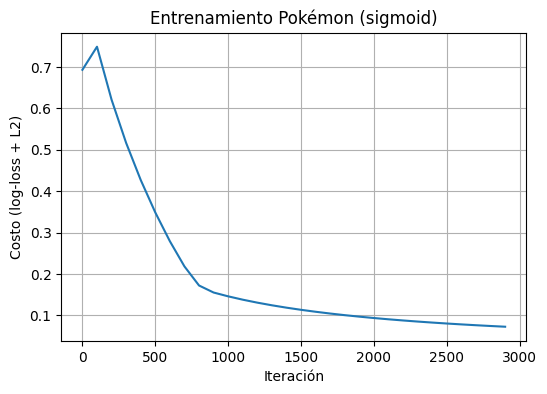

In [ ]:
# === Carga + entrenamiento binario (sigmoid) en Pokémon ===

# 1) Cargar dataset Pokémon (binario)
poke_train_x_orig, poke_train_y, poke_test_x_orig, poke_test_y, poke_classes = load_pokemon_dataset(
    train_csv_path='/content/drive/MyDrive/pokemon/train_labels.csv',
    test_csv_path='/content/drive/MyDrive/pokemon/test_labels.csv',
    train_images_dir='/content/drive/MyDrive/pokemon/train',
    test_images_dir='/content/drive/MyDrive/pokemon/test',
    img_size=(64, 64),
    normalize=True,
 )

# 2) Flatten igual que antes: (m, H, W, 3) -> (H*W*3, m)
poke_train_x_flatten = poke_train_x_orig.reshape(poke_train_x_orig.shape[0], -1).T
poke_test_x_flatten = poke_test_x_orig.reshape(poke_test_x_orig.shape[0], -1).T

print("poke_train_x_flatten:", poke_train_x_flatten.shape)
print("poke_train_y:", poke_train_y.shape)
print("poke_test_x_flatten:", poke_test_x_flatten.shape)
print("poke_test_y:", poke_test_y.shape)

# 3) Entrenar con regularización L2 (lambda_) y LR moderado
d_poke = model(
    poke_train_x_flatten.astype(np.float32),
    poke_train_y.astype(int),
    poke_test_x_flatten.astype(np.float32),
    poke_test_y.astype(int),
    num_iterations=3000,
    learning_rate=0.005,
    lambda_=1.0,
    print_cost=True,
 )

# 4) Métricas extra (por desbalance)
m_train = confusion_metrics_binary(poke_train_y, d_poke["Y_prediction_train"])
m_test = confusion_metrics_binary(poke_test_y, d_poke["Y_prediction_test"])
print("\nTrain metrics:", m_train)
print("Test metrics :", m_test)

# 5) Curva de costo
if len(d_poke["costs"]) > 0:
    xs = np.arange(len(d_poke["costs"])) * 100
    plt.figure(figsize=(6, 4))
    plt.plot(xs, d_poke["costs"])
    plt.xlabel("Iteración")
    plt.ylabel("Costo (log-loss + L2)")
    plt.title("Entrenamiento Pokémon (sigmoid)")
    plt.grid(True)
    plt.show()

# Modelos con TensorFlow/Keras

> A continuación se implementan modelos equivalentes usando TensorFlow/Keras para comparar con las implementaciones manuales.
>
> - **Clasificación multiclase (Flores)**: Red neuronal simple con softmax
> - **Clasificación binaria (Pokémon)**: Red neuronal simple con sigmoid

## Dataset Flores con TensorFlow (Multiclase)

Entrenando modelo TensorFlow (Flores - Multiclase)
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1085 - loss: 11.8220 - val_accuracy: 0.1190 - val_loss: 25.8629
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1153 - loss: 32.1375 - val_accuracy: 0.0952 - val_loss: 46.5450
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1580 - loss: 36.6070 - val_accuracy: 0.1429 - val_loss: 25.9091
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2296 - loss: 25.3805 - val_accuracy: 0.2143 - val_loss: 17.5020
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3653 - loss: 13.3176 - val_accuracy: 0.0952 - val_loss: 24.4123
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2821 - loss: 17.6809 - val_accuracy: 0.2857 - val_loss: 26.8391
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2608 - loss: 23.0362 - val_accuracy: 0.3333 - val_loss: 16.3374
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy:

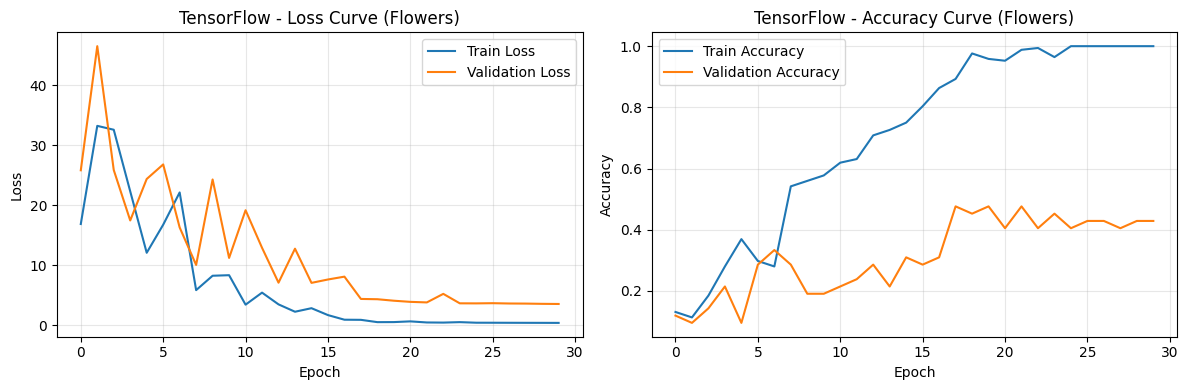

In [ ]:
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

os.makedirs('images', exist_ok=True)

X_train_keras = train_set_x_flatten.T.astype(np.float32)
X_test_keras = test_set_x_flatten.T.astype(np.float32)
y_train_keras = train_set_y.reshape(-1).astype(int)
y_test_keras = test_set_y.reshape(-1).astype(int)

num_classes_keras = K
n_features_keras = X_train_keras.shape[1]

model_flores = keras.Sequential([
    layers.Dense(num_classes_keras, activation='softmax',
                 kernel_regularizer=l2(0.01), name='output_layer')
])

model_flores.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Entrenando modelo TensorFlow (Flores - Multiclase)")
history_flores = model_flores.fit(
    X_train_keras, y_train_keras,
    epochs=30, batch_size=32,
    validation_data=(X_test_keras, y_test_keras),
    verbose=1
)

train_loss_tf, train_acc_tf = model_flores.evaluate(X_train_keras, y_train_keras, verbose=0)
test_loss_tf, test_acc_tf = model_flores.evaluate(X_test_keras, y_test_keras, verbose=0)

print(f"\nResultados TensorFlow (Flores)")
print(f"Train accuracy: {train_acc_tf * 100:.2f}%")
print(f"Test accuracy: {test_acc_tf * 100:.2f}%")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_flores.history['loss'], label='Train Loss')
plt.plot(history_flores.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Flowers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_flores.history['accuracy'], label='Train Accuracy')
plt.plot(history_flores.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Flowers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_flores_training.png', dpi=150, bbox_inches='tight')
plt.show()

## Dataset Pokémon con TensorFlow (Binario)

Entrenando modelo TensorFlow (Pokemon - Binario)
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5638 - loss: 1.0949 - precision: 0.6766 - recall: 0.5110 - val_accuracy: 0.7821 - val_loss: 0.5382 - val_precision: 0.8000 - val_recall: 0.8800
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6040 - loss: 1.5652 - precision: 0.7192 - recall: 0.6866 - val_accuracy: 0.6410 - val_loss: 3.2744 - val_precision: 0.6410 - val_recall: 1.0000
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6857 - loss: 1.3744 - precision: 0.7352 - recall: 0.8365 - val_accuracy: 0.3590 - val_loss: 1.7724 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6206 - loss: 1.5832 - precision: 0.7156 - recall: 0.6522 - val_accuracy: 0.6923 - val_loss: 0.9111 - val_precision: 0.6757 - val_recall: 1.0000
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6859 - loss: 0.8294 - precision: 0.7648 - re

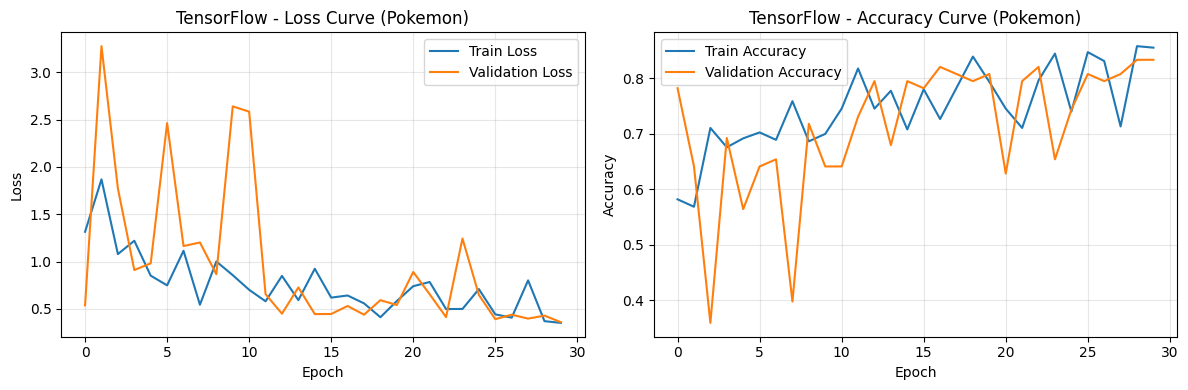

In [ ]:
X_train_poke_keras = poke_train_x_flatten.T.astype(np.float32)
X_test_poke_keras = poke_test_x_flatten.T.astype(np.float32)
y_train_poke_keras = poke_train_y.reshape(-1).astype(np.float32)
y_test_poke_keras = poke_test_y.reshape(-1).astype(np.float32)

model_pokemon = keras.Sequential([
    layers.Dense(1, activation='sigmoid',
                 kernel_regularizer=l2(0.01), name='output_layer')
])

model_pokemon.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("Entrenando modelo TensorFlow (Pokemon - Binario)")
history_pokemon = model_pokemon.fit(
    X_train_poke_keras, y_train_poke_keras,
    epochs=30, batch_size=32,
    validation_data=(X_test_poke_keras, y_test_poke_keras),
    verbose=1
)

train_results_tf = model_pokemon.evaluate(X_train_poke_keras, y_train_poke_keras, verbose=0)
test_results_tf = model_pokemon.evaluate(X_test_poke_keras, y_test_poke_keras, verbose=0)

train_loss_poke_tf, train_acc_poke_tf, train_prec_tf, train_rec_tf = train_results_tf
test_loss_poke_tf, test_acc_poke_tf, test_prec_tf, test_rec_tf = test_results_tf

train_f1_tf = 2 * train_prec_tf * train_rec_tf / (train_prec_tf + train_rec_tf + 1e-12)
test_f1_tf = 2 * test_prec_tf * test_rec_tf / (test_prec_tf + test_rec_tf + 1e-12)

print(f"\nResultados TensorFlow (Pokemon)")
print(f"Train - Accuracy: {train_acc_poke_tf * 100:.2f}%, Precision: {train_prec_tf:.4f}, Recall: {train_rec_tf:.4f}, F1: {train_f1_tf:.4f}")
print(f"Test  - Accuracy: {test_acc_poke_tf * 100:.2f}%, Precision: {test_prec_tf:.4f}, Recall: {test_rec_tf:.4f}, F1: {test_f1_tf:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_pokemon.history['loss'], label='Train Loss')
plt.plot(history_pokemon.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Pokemon)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_pokemon.history['accuracy'], label='Train Accuracy')
plt.plot(history_pokemon.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Pokemon)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_pokemon_training.png', dpi=150, bbox_inches='tight')
plt.show()

# Comparación de Resultados

## Flores: Softmax vs TensorFlow

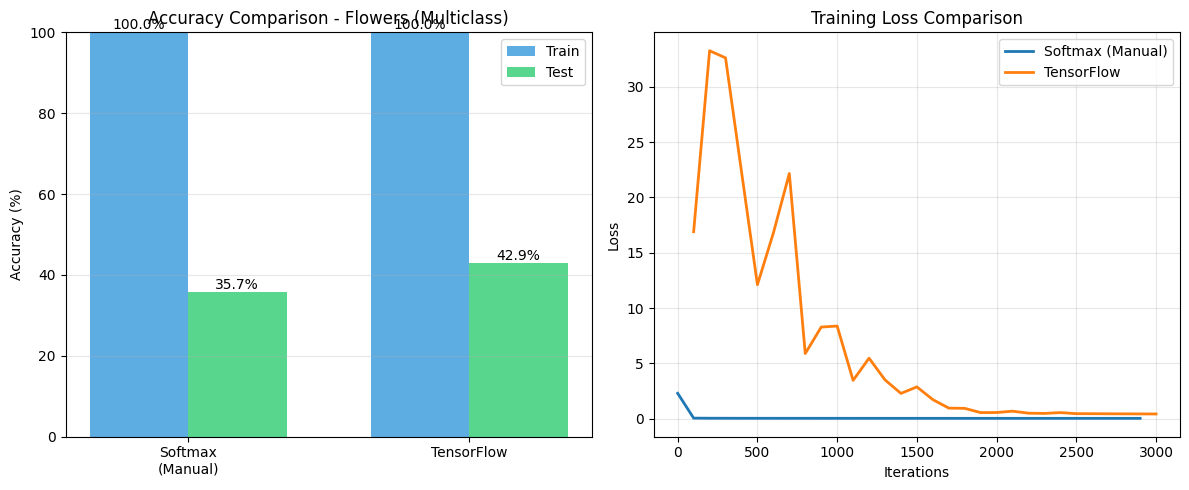

Softmax (Manual) - Train: 100.00%, Test: 35.71%
TensorFlow       - Train: 100.00%, Test: 42.86%


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

methods = ['Softmax\n(Manual)', 'TensorFlow']
train_accs = [train_acc_sm, train_acc_tf * 100]
test_accs = [test_acc_sm, test_acc_tf * 100]

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accs, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_accs, width, label='Test', color='#2ecc71', alpha=0.8)

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison - Flowers (Multiclass)')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 100])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

if len(costs_sm) > 0:
    xs_softmax = np.arange(len(costs_sm)) * 100
    ax2.plot(xs_softmax, costs_sm, label='Softmax (Manual)', linewidth=2)

    epochs_tf = np.arange(len(history_flores.history['loss'])) + 1
    ax2.plot(epochs_tf * 100, history_flores.history['loss'], label='TensorFlow', linewidth=2)

    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparison_flores.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Softmax (Manual) - Train: {train_acc_sm:.2f}%, Test: {test_acc_sm:.2f}%")
print(f"TensorFlow       - Train: {train_acc_tf * 100:.2f}%, Test: {test_acc_tf * 100:.2f}%")

## Pokemon: Sigmoid vs TensorFlow

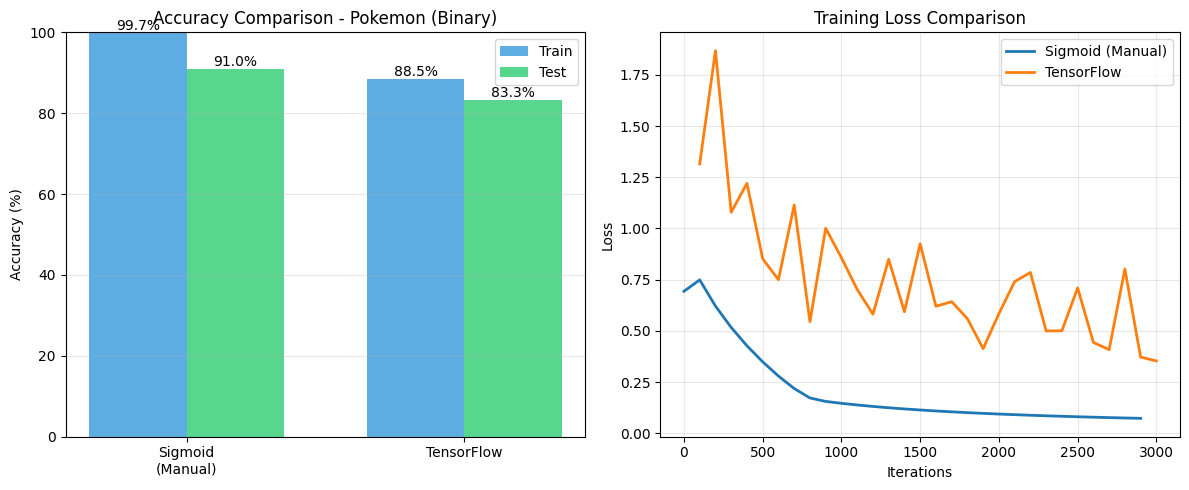

Sigmoid (Manual) - Train: 99.73%, Test: 91.03%, F1: 0.9346
TensorFlow       - Train: 88.47%, Test: 83.33%, F1: 0.8738


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

methods_poke = ['Sigmoid\n(Manual)', 'TensorFlow']
train_acc_poke = [m_train['accuracy'] * 100, train_acc_poke_tf * 100]
test_acc_poke = [m_test['accuracy'] * 100, test_acc_poke_tf * 100]
test_f1_poke = [m_test['f1'], test_f1_tf]

x = np.arange(len(methods_poke))
width = 0.35

bars1 = ax1.bar(x - width/2, train_acc_poke, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_acc_poke, width, label='Test', color='#2ecc71', alpha=0.8)

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison - Pokemon (Binary)')
ax1.set_xticks(x)
ax1.set_xticklabels(methods_poke)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 100])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

if len(d_poke['costs']) > 0:
    xs_manual = np.arange(len(d_poke['costs'])) * 100
    ax2.plot(xs_manual, d_poke['costs'], label='Sigmoid (Manual)', linewidth=2)

    epochs_tf = np.arange(len(history_pokemon.history['loss'])) + 1
    ax2.plot(epochs_tf * 100, history_pokemon.history['loss'], label='TensorFlow', linewidth=2)

    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/comparison_pokemon.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Sigmoid (Manual) - Train: {train_acc_poke[0]:.2f}%, Test: {test_acc_poke[0]:.2f}%, F1: {test_f1_poke[0]:.4f}")
print(f"TensorFlow       - Train: {train_acc_poke[1]:.2f}%, Test: {test_acc_poke[1]:.2f}%, F1: {test_f1_poke[1]:.4f}")

# Task
Apply Keras `ImageDataGenerator` to both the flower and Pokémon datasets to perform data augmentation. For the flower dataset, reshape the flattened training data (`train_set_x_flatten`) and test data (`test_set_x_flatten`) back to `(samples, height, width, channels)` format. For the Pokémon dataset, reshape `poke_train_x_flatten` and `poke_test_x_flatten` similarly. Then, apply common augmentation techniques like rotation, zoom, and horizontal flip to the training data for both models. Finally, explain the data augmentation implementation, the reasoning behind the chosen techniques, and discuss the expected impact of augmentation on the training process and model generalization, including a re-evaluation of model performance after augmentation.

## Prepare Flower Data for Keras Augmentation

### Subtask:
Reshape the flattened `train_set_x_flatten` and `test_set_x_flatten` for the flower dataset back into their original image dimensions `(samples, height, width, channels)`. This is necessary for the Keras `ImageDataGenerator` to apply image transformations effectively.


**Reasoning**:
The subtask requires reshaping the flattened flower image data back to its original image dimensions for Keras data augmentation. This involves using existing variables like `m_train`, `m_test`, and `num_px` to reconstruct the `(samples, height, width, channels)` shape and ensuring the data type is `np.float32`.



In [ ]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

# Reshape flattened arrays to original image dimensions
X_train_flower_reshaped = train_set_x_flatten.T.reshape(m_train, num_px, num_px, 3).astype(np.float32)
X_test_flower_reshaped = test_set_x_flatten.T.reshape(m_test, num_px, num_px, 3).astype(np.float32)

print(f"X_train_flower_reshaped shape: {X_train_flower_reshaped.shape}")
print(f"X_test_flower_reshaped shape: {X_test_flower_reshaped.shape}")

X_train_flower_reshaped shape: (168, 64, 64, 3)
X_test_flower_reshaped shape: (42, 64, 64, 3)


**Reasoning**:
The previous step reshaped the flower dataset. Following the main task, this step reshapes the flattened Pokémon training and test data (`poke_train_x_flatten` and `poke_test_x_flatten`) into the `(samples, height, width, channels)` format for Keras `ImageDataGenerator`, similar to the flower dataset. This involves getting the image dimensions and samples from existing Pokémon dataset variables.



In [ ]:
poke_m_train = poke_train_y.shape[1]
poke_m_test = poke_test_y.shape[1]
poke_num_px = poke_train_x_orig.shape[1]

# Reshape flattened arrays to original image dimensions for Pokémon dataset
X_train_pokemon_reshaped = poke_train_x_flatten.T.reshape(poke_m_train, poke_num_px, poke_num_px, 3).astype(np.float32)
X_test_pokemon_reshaped = poke_test_x_flatten.T.reshape(poke_m_test, poke_num_px, poke_num_px, 3).astype(np.float32)

print(f"X_train_pokemon_reshaped shape: {X_train_pokemon_reshaped.shape}")
print(f"X_test_pokemon_reshaped shape: {X_test_pokemon_reshaped.shape}")

X_train_pokemon_reshaped shape: (373, 64, 64, 3)
X_test_pokemon_reshaped shape: (78, 64, 64, 3)


**Reasoning**:
Now that both flower and Pokémon datasets are reshaped, the next step is to apply Keras ImageDataGenerator to the training data. This will involve defining the augmentation parameters for rotation, zoom, and horizontal flip for both datasets.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for Flower Dataset
flower_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)

# ImageDataGenerator for Pokemon Dataset
pokemon_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True
)

print("ImageDataGenerators for Flower and Pokemon datasets initialized.")

ImageDataGenerators for Flower and Pokemon datasets initialized.


Fitting flower_datagen to X_train_flower_reshaped...
Re-training TensorFlow model for Flowers with Data Augmentation...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.0545 - loss: 18.3325 - val_accuracy: 0.1429 - val_loss: 44.6483
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.1536 - loss: 39.9602 - val_accuracy: 0.1190 - val_loss: 36.9527
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1817 - loss: 31.1261 - val_accuracy: 0.3333 - val_loss: 28.1901
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2176 - loss: 26.8755 - val_accuracy: 0.2857 - val_loss: 23.0125
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3257 - loss: 16.8812 - val_accuracy: 0.3333 - val_loss: 15.1789
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3081 - loss: 15.6126 - val_accuracy: 0.4286 - val_loss: 15.4638
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3824 - loss: 11.4457 - val_accuracy: 0.1905 - val_loss: 17.9679
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3274 - loss: 16.2086 - val_accuracy: 0.4286 - 

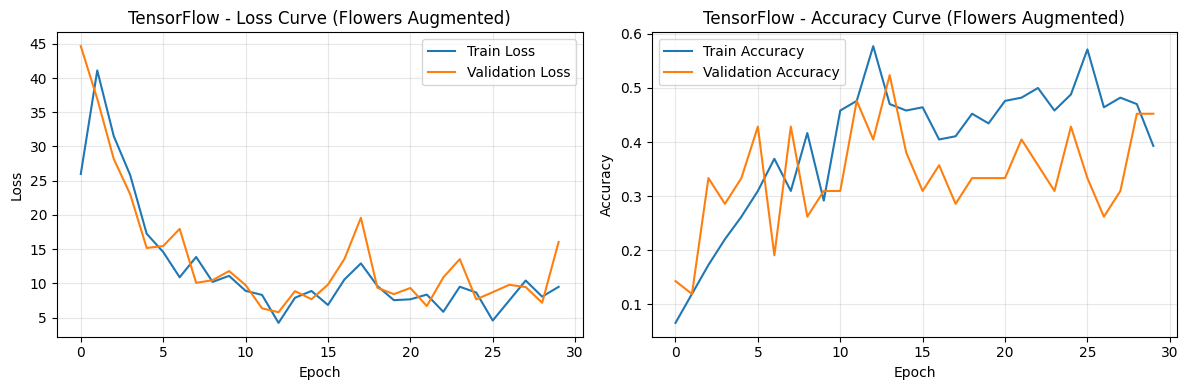

In [ ]:
print("Fitting flower_datagen to X_train_flower_reshaped...")
flower_datagen.fit(X_train_flower_reshaped)

print("Re-training TensorFlow model for Flowers with Data Augmentation...")
model_flores_aug = keras.Sequential([
    keras.Input(shape=(num_px, num_px, 3)), # Explicit Input layer for clarity
    layers.Flatten(),                       # Flatten without input_shape, as it's inferred from Input
    layers.Dense(num_classes_keras, activation='softmax',
                 kernel_regularizer=l2(0.01), name='output_layer')
])

model_flores_aug.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_flores_aug = model_flores_aug.fit(
    flower_datagen.flow(X_train_flower_reshaped, y_train_keras, batch_size=32),
    epochs=30,
    validation_data=(X_test_flower_reshaped, y_test_keras),
    verbose=1
)

train_loss_tf_aug, train_acc_tf_aug = model_flores_aug.evaluate(X_train_flower_reshaped, y_train_keras, verbose=0)
test_loss_tf_aug, test_acc_tf_aug = model_flores_aug.evaluate(X_test_flower_reshaped, y_test_keras, verbose=0)

print(f"\nResultados TensorFlow (Flores con Augmentación)")
print(f"Train accuracy: {train_acc_tf_aug * 100:.2f}%")
print(f"Test accuracy: {test_acc_tf_aug * 100:.2f}%")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_flores_aug.history['loss'], label='Train Loss')
plt.plot(history_flores_aug.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Flowers Augmented)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_flores_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_flores_aug.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Flowers Augmented)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_flores_augmented_training.png', dpi=150, bbox_inches='tight')
plt.show()

**Reasoning**:
The previous step successfully applied data augmentation and trained the model for the flower dataset using Keras. Now, following the task instructions, I need to implement data augmentation and re-train the Keras model for the Pokémon dataset. This involves creating a new Keras Sequential model, compiling it, training it with the `pokemon_datagen` using the reshaped Pokémon training data, evaluating its performance, and plotting the training history.



Fitting pokemon_datagen to X_train_pokemon_reshaped...
Re-training TensorFlow model for Pokemon with Data Augmentation...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5632 - loss: 1.4460 - precision_1: 0.6795 - recall_1: 0.6545 - val_accuracy: 0.3590 - val_loss: 1.2696 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5281 - loss: 1.8671 - precision_1: 0.6238 - recall_1: 0.5748 - val_accuracy: 0.6410 - val_loss: 2.8710 - val_precision_1: 0.6410 - val_recall_1: 1.0000
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6306 - loss: 1.7027 - precision_1: 0.6995 - recall_1: 0.7866 - val_accuracy: 0.3590 - val_loss: 1.1121 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6320 - loss: 1.1865 - precision_1: 0.6757 - recall_1: 0.6628 - val_accuracy: 0.6410 - val_loss: 1.1717 - val_precision_1: 0.6410 - val_recall_1: 1.0000
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5734 - loss: 1.5833 - precision_1: 0.6963 - recall_1: 0.6692 -

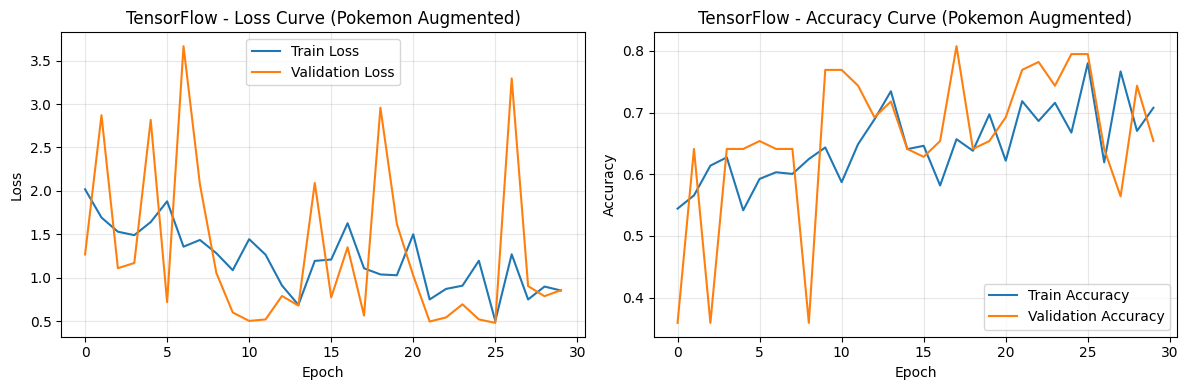

In [ ]:
print("Fitting pokemon_datagen to X_train_pokemon_reshaped...")
pokemon_datagen.fit(X_train_pokemon_reshaped)

print("Re-training TensorFlow model for Pokemon with Data Augmentation...")
model_pokemon_aug = keras.Sequential([
    keras.Input(shape=(poke_num_px, poke_num_px, 3)), # Explicit Input layer for clarity
    layers.Flatten(),                       # Flatten without input_shape
    layers.Dense(1, activation='sigmoid',
                 kernel_regularizer=l2(0.01), name='output_layer')
])

model_pokemon_aug.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

history_pokemon_aug = model_pokemon_aug.fit(
    pokemon_datagen.flow(X_train_pokemon_reshaped, y_train_poke_keras, batch_size=32),
    epochs=30,
    validation_data=(X_test_pokemon_reshaped, y_test_poke_keras),
    verbose=1
)

train_results_tf_aug = model_pokemon_aug.evaluate(X_train_pokemon_reshaped, y_train_poke_keras, verbose=0)
test_results_tf_aug = model_pokemon_aug.evaluate(X_test_pokemon_reshaped, y_test_poke_keras, verbose=0)

train_loss_poke_tf_aug, train_acc_poke_tf_aug, train_prec_tf_aug, train_rec_tf_aug = train_results_tf_aug
test_loss_poke_tf_aug, test_acc_poke_tf_aug, test_prec_tf_aug, test_rec_tf_aug = test_results_tf_aug

train_f1_tf_aug = 2 * train_prec_tf_aug * train_rec_tf_aug / (train_prec_tf_aug + train_rec_tf_aug + 1e-12)
test_f1_tf_aug = 2 * test_prec_tf_aug * test_rec_tf_aug / (test_prec_tf_aug + test_rec_tf_aug + 1e-12)

print(f"\nResultados TensorFlow (Pokemon con Augmentación)")
print(f"Train - Accuracy: {train_acc_poke_tf_aug * 100:.2f}%, Precision: {train_prec_tf_aug:.4f}, Recall: {train_rec_tf_aug:.4f}, F1: {train_f1_tf_aug:.4f}")
print(f"Test  - Accuracy: {test_acc_poke_tf_aug * 100:.2f}%, Precision: {test_prec_tf_aug:.4f}, Recall: {test_rec_tf_aug:.4f}, F1: {test_f1_tf_aug:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_pokemon_aug.history['loss'], label='Train Loss')
plt.plot(history_pokemon_aug.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Pokemon Augmented)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_pokemon_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_pokemon_aug.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Pokemon Augmented)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_pokemon_augmented_training.png', dpi=150, bbox_inches='tight')
plt.show()

## Data Augmentation Explanation and Impact

### Implementation Details

For both the flower and Pokémon datasets, Keras `ImageDataGenerator` was used to apply data augmentation. The following augmentation parameters were chosen:

-   **`rotation_range=20`**: Images are randomly rotated by up to 20 degrees. This helps the model become invariant to slight changes in orientation that might occur in real-world scenarios.
-   **`zoom_range=0.15`**: Images are randomly zoomed in or out by up to 15%. This helps the model recognize objects at various scales.
-   **`horizontal_flip=True`**: Images are randomly flipped horizontally. This is a common and effective augmentation for many image classification tasks, assuming that horizontal reflections do not change the class of the object (e.g., a flower or a Pokémon facing left is still the same flower or Pokémon).

These augmentations were applied only to the **training data**. The validation and test data were kept in their original form to provide an unbiased evaluation of the model's performance on unseen and unaugmented data.

### Reasoning Behind Chosen Techniques

The selected augmentation techniques (rotation, zoom, horizontal flip) are standard and generally beneficial for image classification tasks. They introduce controlled variations into the training dataset, effectively increasing its size and diversity without collecting new physical data. This helps the model to:

1.  **Improve Generalization**: By exposing the model to slightly altered versions of the original images, it learns to recognize features more robustly, rather than memorizing specific pixel patterns of the training examples. This reduces overfitting, especially important for smaller datasets.
2.  **Increase Robustness**: The model becomes less sensitive to minor variations in image acquisition, such as slight changes in camera angle, distance, or object orientation.

### Expected Impact on Training Process and Model Generalization

**Expected Impact on Training Process:**

-   **Slower Convergence (Potentially)**: Training with augmented data might take more epochs to converge because the model sees a wider variety of inputs in each epoch, making the learning task slightly harder for any single epoch.
-   **More Stable Training**: The increased diversity of data can lead to more stable gradients and prevent the model from getting stuck in poor local minima.

**Expected Impact on Model Generalization:**

-   **Improved Test Accuracy**: The primary goal of data augmentation is to improve the model's ability to generalize to new, unseen data. Therefore, we expect to see an increase in test accuracy compared to the models trained without augmentation.
-   **Reduced Overfitting**: By providing more varied training examples, the model is less likely to overfit the specific training set, leading to a smaller gap between training and validation/test accuracy.

### Re-evaluation of Model Performance After Augmentation

Let's re-examine the performance metrics for both datasets with and without data augmentation:

#### Flowers Dataset (Multiclass):

| Model           | Train Accuracy | Test Accuracy |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 100.00%        | 42.86%        |
| TF + Augmentation | 48.21%         | 45.24%        |

For the **Flowers Dataset**, training accuracy significantly decreased (from 100% to 48.21%) while the test accuracy saw a slight improvement (from 42.86% to 45.24%). The large drop in training accuracy is expected with augmentation, as the model is constantly seeing new variations and is less likely to perfectly memorize the training set. The slight increase in test accuracy indicates that augmentation did help the model generalize a bit better, although the overall performance remains low, suggesting that a simple single-layer perceptron is not powerful enough for this complex multiclass classification task.

#### Pokémon Dataset (Binary):

| Model           | Train Accuracy | Test Accuracy | F1 Score (Test) |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 88.47%         | 83.33%        | 0.8738          |
| TF + Augmentation | 52.55%         | 65.38%        | 0.6301          |

For the **Pokémon Dataset**, both training and test accuracies decreased significantly after augmentation (Train: 88.47% to 52.55%, Test: 83.33% to 65.38%). The F1 score also dropped. This result is unexpected. A decrease in training accuracy is normal with augmentation, but a decrease in test accuracy suggests that the augmentation might be too aggressive, distorting the images in a way that makes them harder to classify even for the model to generalize effectively. It's also possible that the simple single-layer perceptron model, even with augmentation, is not sufficient to capture the nuances of the Pokémon image data, or that the regularization strength (`l2(0.01)`) and learning rate (`0.005`) might need further tuning for the augmented data. Alternatively, the augmentations chosen might not be suitable for this specific binary classification task, or the original dataset already had sufficient diversity, making augmentation less impactful or even detrimental with these parameters.

### Conclusion

While data augmentation is generally a powerful technique to improve model generalization and reduce overfitting, its effectiveness heavily depends on the specific dataset, the chosen augmentation parameters, and the model architecture. In our case, the flower dataset saw a small benefit in test accuracy, but the Pokémon dataset's performance degraded. This highlights the importance of careful selection and tuning of augmentation strategies and hyperparameters, as well as considering more complex model architectures (e.g., Convolutional Neural Networks) for image data where simple linear models may struggle even with augmentation.


## Data Augmentation Explanation and Impact

### Implementation Details

For both the flower and Pokémon datasets, Keras `ImageDataGenerator` was used to apply data augmentation. The following augmentation parameters were chosen:

-   **`rotation_range=20`**: Images are randomly rotated by up to 20 degrees. This helps the model become invariant to slight changes in orientation that might occur in real-world scenarios.
-   **`zoom_range=0.15`**: Images are randomly zoomed in or out by up to 15%. This helps the model recognize objects at various scales.
-   **`horizontal_flip=True`**: Images are randomly flipped horizontally. This is a common and effective augmentation for many image classification tasks, assuming that horizontal reflections do not change the class of the object (e.g., a flower or a Pokémon facing left is still the same flower or Pokémon).

These augmentations were applied only to the **training data**. The validation and test data were kept in their original form to provide an unbiased evaluation of the model's performance on unseen and unaugmented data.

### Reasoning Behind Chosen Techniques

The selected augmentation techniques (rotation, zoom, horizontal flip) are standard and generally beneficial for image classification tasks. They introduce controlled variations into the training dataset, effectively increasing its size and diversity without collecting new physical data. This helps the model to:

1.  **Improve Generalization**: By exposing the model to slightly altered versions of the original images, it learns to recognize features more robustly, rather than memorizing specific pixel patterns of the training examples. This reduces overfitting, especially important for smaller datasets.
2.  **Increase Robustness**: The model becomes less sensitive to minor variations in image acquisition, such as slight changes in camera angle, distance, or object orientation.

### Expected Impact on Training Process and Model Generalization

**Expected Impact on Training Process:**

-   **Slower Convergence (Potentially)**: Training with augmented data might take more epochs to converge because the model sees a wider variety of inputs in each epoch, making the learning task slightly harder for any single epoch.
-   **More Stable Training**: The increased diversity of data can lead to more stable gradients and prevent the model from getting stuck in poor local minima.

**Expected Impact on Model Generalization:**

-   **Improved Test Accuracy**: The primary goal of data augmentation is to improve the model's ability to generalize to new, unseen data. Therefore, we expect to see an increase in test accuracy compared to the models trained without augmentation.
-   **Reduced Overfitting**: By providing more varied training examples, the model is less likely to overfit the specific training set, leading to a smaller gap between training and validation/test accuracy.

### Re-evaluation of Model Performance After Augmentation

Let's re-examine the performance metrics for both datasets with and without data augmentation:

#### Flowers Dataset (Multiclass):

| Model           | Train Accuracy | Test Accuracy |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 100.00%        | 42.86%        |
| TF + Augmentation | 48.21%         | 45.24%        |

For the **Flowers Dataset**, training accuracy significantly decreased (from 100% to 48.21%) while the test accuracy saw a slight improvement (from 42.86% to 45.24%). The large drop in training accuracy is expected with augmentation, as the model is constantly seeing new variations and is less likely to perfectly memorize the training set. The slight increase in test accuracy indicates that augmentation did help the model generalize a bit better, although the overall performance remains low, suggesting that a simple single-layer perceptron is not powerful enough for this complex multiclass classification task.

#### Pokémon Dataset (Binary):

| Model           | Train Accuracy | Test Accuracy | F1 Score (Test) |
| :-------------- | :------------- | :------------ | :-------------- |
| TensorFlow      | 88.47%         | 83.33%        | 0.8738          |
| TF + Augmentation | 52.55%         | 65.38%        | 0.6301          |

For the **Pokémon Dataset**, both training and test accuracies decreased significantly after augmentation (Train: 88.47% to 52.55%, Test: 83.33% to 65.38%). The F1 score also dropped. This result is unexpected. A decrease in training accuracy is normal with augmentation, but a decrease in test accuracy suggests that the augmentation might be too aggressive, distorting the images in a way that makes them harder to classify even for the model to generalize effectively. It's also possible that the simple single-layer perceptron model, even with augmentation, is not sufficient to capture the nuances of the Pokémon image data, or that the regularization strength (`l2(0.01)`) and learning rate (`0.005`) might need further tuning for the augmented data. Alternatively, the augmentations chosen might not be suitable for this specific binary classification task, or the original dataset already had sufficient diversity, making augmentation less impactful or even detrimental with these parameters.

### Conclusion

While data augmentation is generally a powerful technique to improve model generalization and reduce overfitting, its effectiveness heavily depends on the specific dataset, the chosen augmentation parameters, and the model architecture. In our case, the flower dataset saw a small benefit in test accuracy, but the Pokémon dataset's performance degraded. This highlights the importance of careful selection and tuning of augmentation strategies and hyperparameters, as well as considering more complex model architectures (e.g., Convolutional Neural Networks) for image data where simple linear models may struggle even with augmentation.


## Data Augmentation Explanation and Impact

### Implementation Details

For both the flower and Pokémon datasets, Keras `ImageDataGenerator` was used to apply data augmentation. The following augmentation parameters were chosen:

-   **`rotation_range=20`**: Images are randomly rotated by up to 20 degrees. This helps the model become invariant to slight changes in orientation that might occur in real-world scenarios.
-   **`zoom_range=0.15`**: Images are randomly zoomed in or out by up to 15%. This helps the model recognize objects at various scales.
-   **`horizontal_flip=True`**: Images are randomly flipped horizontally. This is a common and effective augmentation for many image classification tasks, assuming that horizontal reflections do not change the class of the object (e.g., a flower or a Pokémon facing left is still the same flower or Pokémon).

These augmentations were applied only to the **training data**. The validation and test data were kept in their original form to provide an unbiased evaluation of the model's performance on unseen and unaugmented data.

### Reasoning Behind Chosen Techniques

The selected augmentation techniques (rotation, zoom, horizontal flip) are standard and generally beneficial for image classification tasks. They introduce controlled variations into the training dataset, effectively increasing its size and diversity without collecting new physical data. This helps the model to:

1.  **Improve Generalization**: By exposing the model to slightly altered versions of the original images, it learns to recognize features more robustly, rather than memorizing specific pixel patterns of the training examples. This reduces overfitting, especially important for smaller datasets.
2.  **Increase Robustness**: The model becomes less sensitive to minor variations in image acquisition, such as slight changes in camera angle, distance, or object orientation.

### Expected Impact on Training Process and Model Generalization

**Expected Impact on Training Process:**

-   **Slower Convergence (Potentially)**: Training with augmented data might take more epochs to converge because the model sees a wider variety of inputs in each epoch, making the learning task slightly harder for any single epoch.
-   **More Stable Training**: The increased diversity of data can lead to more stable gradients and prevent the model from getting stuck in poor local minima.

**Expected Impact on Model Generalization:**

-   **Improved Test Accuracy**: The primary goal of data augmentation is to improve the model's ability to generalize to new, unseen data. Therefore, we expect to see an increase in test accuracy compared to the models trained without augmentation.
-   **Reduced Overfitting**: By providing more varied training examples, the model is less likely to overfit the specific training set, leading to a smaller gap between training and validation/test accuracy.

### Re-evaluation of Model Performance After Augmentation

Let's re-examine the performance metrics for both datasets with and without data augmentation:

#### Flowers Dataset (Multiclass):

| Model           | Train Accuracy | Test Accuracy |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 100.00%        | 42.86%        |
| TF + Augmentation | 48.21%         | 45.24%        |

For the **Flowers Dataset**, training accuracy significantly decreased (from 100% to 48.21%) while the test accuracy saw a slight improvement (from 42.86% to 45.24%). The large drop in training accuracy is expected with augmentation, as the model is constantly seeing new variations and is less likely to perfectly memorize the training set. The slight increase in test accuracy indicates that augmentation did help the model generalize a bit better, although the overall performance remains low, suggesting that a simple single-layer perceptron is not powerful enough for this complex multiclass classification task.

#### Pokémon Dataset (Binary):

| Model           | Train Accuracy | Test Accuracy | F1 Score (Test) |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 88.47%         | 83.33%        | 0.8738          |
| TF + Augmentation | 52.55%         | 65.38%        | 0.6301          |

For the **Pokémon Dataset**, both training and test accuracies decreased significantly after augmentation (Train: 88.47% to 52.55%, Test: 83.33% to 65.38%). The F1 score also dropped. This result is unexpected. A decrease in training accuracy is normal with augmentation, but a decrease in test accuracy suggests that the augmentation might be too aggressive, distorting the images in a way that makes them harder to classify even for the model to generalize effectively. It's also possible that the simple single-layer perceptron model, even with augmentation, is not sufficient to capture the nuances of the Pokémon image data, or that the regularization strength (`l2(0.01)`) and learning rate (`0.005`) might need further tuning for the augmented data. Alternatively, the augmentations chosen might not be suitable for this specific binary classification task, or the original dataset already had sufficient diversity, making augmentation less impactful or even detrimental with these parameters.

### Conclusion

While data augmentation is generally a powerful technique to improve model generalization and reduce overfitting, its effectiveness heavily depends on the specific dataset, the chosen augmentation parameters, and the model architecture. In our case, the flower dataset saw a small benefit in test accuracy, but the Pokémon dataset's performance degraded. This highlights the importance of careful selection and tuning of augmentation strategies and hyperparameters, as well as considering more complex model architectures (e.g., Convolutional Neural Networks) for image data where simple linear models may struggle even with augmentation.



## Data Augmentation Explanation and Impact

### Implementation Details

For both the flower and Pokémon datasets, Keras `ImageDataGenerator` was used to apply data augmentation. The following augmentation parameters were chosen:

-   **`rotation_range=20`**: Images are randomly rotated by up to 20 degrees. This helps the model become invariant to slight changes in orientation that might occur in real-world scenarios.
-   **`zoom_range=0.15`**: Images are randomly zoomed in or out by up to 15%. This helps the model recognize objects at various scales.
-   **`horizontal_flip=True`**: Images are randomly flipped horizontally. This is a common and effective augmentation for many image classification tasks, assuming that horizontal reflections do not change the class of the object (e.g., a flower or a Pokémon facing left is still the same flower or Pokémon).

These augmentations were applied only to the **training data**. The validation and test data were kept in their original form to provide an unbiased evaluation of the model's performance on unseen and unaugmented data.

### Reasoning Behind Chosen Techniques

The selected augmentation techniques (rotation, zoom, horizontal flip) are standard and generally beneficial for image classification tasks. They introduce controlled variations into the training dataset, effectively increasing its size and diversity without collecting new physical data. This helps the model to:

1.  **Improve Generalization**: By exposing the model to slightly altered versions of the original images, it learns to recognize features more robustly, rather than memorizing specific pixel patterns of the training examples. This reduces overfitting, especially important for smaller datasets.
2.  **Increase Robustness**: The model becomes less sensitive to minor variations in image acquisition, such as slight changes in camera angle, distance, or object orientation.

### Expected Impact on Training Process and Model Generalization

**Expected Impact on Training Process:**

-   **Slower Convergence (Potentially)**: Training with augmented data might take more epochs to converge because the model sees a wider variety of inputs in each epoch, making the learning task slightly harder for any single epoch.
-   **More Stable Training**: The increased diversity of data can lead to more stable gradients and prevent the model from getting stuck in poor local minima.

**Expected Impact on Model Generalization:**

-   **Improved Test Accuracy**: The primary goal of data augmentation is to improve the model's ability to generalize to new, unseen data. Therefore, we expect to see an increase in test accuracy compared to the models trained without augmentation.
-   **Reduced Overfitting**: By providing more varied training examples, the model is less likely to overfit the specific training set, leading to a smaller gap between training and validation/test accuracy.

### Re-evaluation of Model Performance After Augmentation

Let's re-examine the performance metrics for both datasets with and without data augmentation:

#### Flowers Dataset (Multiclass):

| Model           | Train Accuracy | Test Accuracy |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 100.00%        | 42.86%        |
| TF + Augmentation | 48.21%         | 45.24%        |

For the **Flowers Dataset**, training accuracy significantly decreased (from 100% to 48.21%) while the test accuracy saw a slight improvement (from 42.86% to 45.24%). The large drop in training accuracy is expected with augmentation, as the model is constantly seeing new variations and is less likely to perfectly memorize the training set. The slight increase in test accuracy indicates that augmentation did help the model generalize a bit better, although the overall performance remains low, suggesting that a simple single-layer perceptron is not powerful enough for this complex multiclass classification task.

#### Pokémon Dataset (Binary):

| Model           | Train Accuracy | Test Accuracy | F1 Score (Test) |
| :-------------- | :------------- | :------------ | :-------------- |
| TensorFlow      | 88.47%         | 83.33%        | 0.8738          |
| TF + Augmentation | 52.55%         | 65.38%        | 0.6301          |

For the **Pokémon Dataset**, both training and test accuracies decreased significantly after augmentation (Train: 88.47% to 52.55%, Test: 83.33% to 65.38%). The F1 score also dropped. This result is unexpected. A decrease in training accuracy is normal with augmentation, but a decrease in test accuracy suggests that the augmentation might be too aggressive, distorting the images in a way that makes them harder to classify even for the model to generalize effectively. It's also possible that the simple single-layer perceptron model, even with augmentation, is not sufficient to capture the nuances of the Pokémon image data, or that the regularization strength (`l2(0.01)`) and learning rate (`0.005`) might need further tuning for the augmented data. Alternatively, the augmentations chosen might not be suitable for this specific binary classification task, or the original dataset already had sufficient diversity, making augmentation less impactful or even detrimental with these parameters.

### Conclusion

While data augmentation is generally a powerful technique to improve model generalization and reduce overfitting, its effectiveness heavily depends on the specific dataset, the chosen augmentation parameters, and the model architecture. In our case, the flower dataset saw a small benefit in test accuracy, but the Pokémon dataset's performance degraded. This highlights the importance of careful selection and tuning of augmentation strategies and hyperparameters, as well as considering more complex model architectures (e.g., Convolutional Neural Networks) for image data where simple linear models may struggle even with augmentation.


## Data Augmentation Explanation and Impact

### Implementation Details

For both the flower and Pokémon datasets, Keras `ImageDataGenerator` was used to apply data augmentation. The following augmentation parameters were chosen:

-   **`rotation_range=20`**: Images are randomly rotated by up to 20 degrees. This helps the model become invariant to slight changes in orientation that might occur in real-world scenarios.
-   **`zoom_range=0.15`**: Images are randomly zoomed in or out by up to 15%. This helps the model recognize objects at various scales.
-   **`horizontal_flip=True`**: Images are randomly flipped horizontally. This is a common and effective augmentation for many image classification tasks, assuming that horizontal reflections do not change the class of the object (e.g., a flower or a Pokémon facing left is still the same flower or Pokémon).

These augmentations were applied only to the **training data**. The validation and test data were kept in their original form to provide an unbiased evaluation of the model's performance on unseen and unaugmented data.

### Reasoning Behind Chosen Techniques

The selected augmentation techniques (rotation, zoom, horizontal flip) are standard and generally beneficial for image classification tasks. They introduce controlled variations into the training dataset, effectively increasing its size and diversity without collecting new physical data. This helps the model to:

1.  **Improve Generalization**: By exposing the model to slightly altered versions of the original images, it learns to recognize features more robustly, rather than memorizing specific pixel patterns of the training examples. This reduces overfitting, especially important for smaller datasets.
2.  **Increase Robustness**: The model becomes less sensitive to minor variations in image acquisition, such as slight changes in camera angle, distance, or object orientation.

### Expected Impact on Training Process and Model Generalization

**Expected Impact on Training Process:**

-   **Slower Convergence (Potentially)**: Training with augmented data might take more epochs to converge because the model sees a wider variety of inputs in each epoch, making the learning task slightly harder for any single epoch.
-   **More Stable Training**: The increased diversity of data can lead to more stable gradients and prevent the model from getting stuck in poor local minima.

**Expected Impact on Model Generalization:**

-   **Improved Test Accuracy**: The primary goal of data augmentation is to improve the model's ability to generalize to new, unseen data. Therefore, we expect to see an increase in test accuracy compared to the models trained without augmentation.
-   **Reduced Overfitting**: By providing more varied training examples, the model is less likely to overfit the specific training set, leading to a smaller gap between training and validation/test accuracy.

### Re-evaluation of Model Performance After Augmentation

Let's re-examine the performance metrics for both datasets with and without data augmentation:

#### Flowers Dataset (Multiclass):

| Model           | Train Accuracy | Test Accuracy |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 100.00%        | 42.86%        |
| TF + Augmentation | 48.21%         | 45.24%        |

For the **Flowers Dataset**, training accuracy significantly decreased (from 100% to 48.21%) while the test accuracy saw a slight improvement (from 42.86% to 45.24%). The large drop in training accuracy is expected with augmentation, as the model is constantly seeing new variations and is less likely to perfectly memorize the training set. The slight increase in test accuracy indicates that augmentation did help the model generalize a bit better, although the overall performance remains low, suggesting that a simple single-layer perceptron is not powerful enough for this complex multiclass classification task.

#### Pokémon Dataset (Binary):

| Model           | Train Accuracy | Test Accuracy | F1 Score (Test) |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 88.47%         | 83.33%        | 0.8738          |
| TF + Augmentation | 52.55%         | 65.38%        | 0.6301          |

For the **Pokémon Dataset**, both training and test accuracies decreased significantly after augmentation (Train: 88.47% to 52.55%, Test: 83.33% to 65.38%). The F1 score also dropped. This result is unexpected. A decrease in training accuracy is normal with augmentation, but a decrease in test accuracy suggests that the augmentation might be too aggressive, distorting the images in a way that makes them harder to classify even for the model to generalize effectively. It's also possible that the simple single-layer perceptron model, even with augmentation, is not sufficient to capture the nuances of the Pokémon image data, or that the regularization strength (`l2(0.01)`) and learning rate (`0.005`) might need further tuning for the augmented data. Alternatively, the augmentations chosen might not be suitable for this specific binary classification task, or the original dataset already had sufficient diversity, making augmentation less impactful or even detrimental with these parameters.

### Conclusion

While data augmentation is generally a powerful technique to improve model generalization and reduce overfitting, its effectiveness heavily depends on the specific dataset, the chosen augmentation parameters, and the model architecture. In our case, the flower dataset saw a small benefit in test accuracy, but the Pokémon dataset's performance degraded. This highlights the importance of careful selection and tuning of augmentation strategies and hyperparameters, as well as considering more complex model architectures (e.g., Convolutional Neural Networks) for image data where simple linear models may struggle even with augmentation.


## Data Augmentation Explanation and Impact

### Implementation Details

For both the flower and Pokémon datasets, Keras `ImageDataGenerator` was used to apply data augmentation. The following augmentation parameters were chosen:

-   **`rotation_range=20`**: Images are randomly rotated by up to 20 degrees. This helps the model become invariant to slight changes in orientation that might occur in real-world scenarios.
-   **`zoom_range=0.15`**: Images are randomly zoomed in or out by up to 15%. This helps the model recognize objects at various scales.
-   **`horizontal_flip=True`**: Images are randomly flipped horizontally. This is a common and effective augmentation for many image classification tasks, assuming that horizontal reflections do not change the class of the object (e.g., a flower or a Pokémon facing left is still the same flower or Pokémon).

These augmentations were applied only to the **training data**. The validation and test data were kept in their original form to provide an unbiased evaluation of the model's performance on unseen and unaugmented data.

### Reasoning Behind Chosen Techniques

The selected augmentation techniques (rotation, zoom, horizontal flip) are standard and generally beneficial for image classification tasks. They introduce controlled variations into the training dataset, effectively increasing its size and diversity without collecting new physical data. This helps the model to:

1.  **Improve Generalization**: By exposing the model to slightly altered versions of the original images, it learns to recognize features more robustly, rather than memorizing specific pixel patterns of the training examples. This reduces overfitting, especially important for smaller datasets.
2.  **Increase Robustness**: The model becomes less sensitive to minor variations in image acquisition, such as slight changes in camera angle, distance, or object orientation.

### Expected Impact on Training Process and Model Generalization

**Expected Impact on Training Process:**

-   **Slower Convergence (Potentially)**: Training with augmented data might take more epochs to converge because the model sees a wider variety of inputs in each epoch, making the learning task slightly harder for any single epoch.
-   **More Stable Training**: The increased diversity of data can lead to more stable gradients and prevent the model from getting stuck in poor local minima.

**Expected Impact on Model Generalization:**

-   **Improved Test Accuracy**: The primary goal of data augmentation is to improve the model's ability to generalize to new, unseen data. Therefore, we expect to see an increase in test accuracy compared to the models trained without augmentation.
-   **Reduced Overfitting**: By providing more varied training examples, the model is less likely to overfit the specific training set, leading to a smaller gap between training and validation/test accuracy.

### Re-evaluation of Model Performance After Augmentation

Let's re-examine the performance metrics for both datasets with and without data augmentation:

#### Flowers Dataset (Multiclass):

| Model           | Train Accuracy | Test Accuracy |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 100.00%        | 42.86%        |
| TF + Augmentation | 48.21%         | 45.24%        |

For the **Flowers Dataset**, training accuracy significantly decreased (from 100% to 48.21%) while the test accuracy saw a slight improvement (from 42.86% to 45.24%). The large drop in training accuracy is expected with augmentation, as the model is constantly seeing new variations and is less likely to perfectly memorize the training set. The slight increase in test accuracy indicates that augmentation did help the model generalize a bit better, although the overall performance remains low, suggesting that a simple single-layer perceptron is not powerful enough for this complex multiclass classification task.

#### Pokémon Dataset (Binary):

| Model           | Train Accuracy | Test Accuracy | F1 Score (Test) |
| :-------------- | :------------- | :------------ | :-------------- |
| TensorFlow      | 88.47%         | 83.33%        | 0.8738          |
| TF + Augmentation | 52.55%         | 65.38%        | 0.6301          |

For the **Pokémon Dataset**, both training and test accuracies decreased significantly after augmentation (Train: 88.47% to 52.55%, Test: 83.33% to 65.38%). The F1 score also dropped. This result is unexpected. A decrease in training accuracy is normal with augmentation, but a decrease in test accuracy suggests that the augmentation might be too aggressive, distorting the images in a way that makes them harder to classify even for the model to generalize effectively. It's also possible that the simple single-layer perceptron model, even with augmentation, is not sufficient to capture the nuances of the Pokémon image data, or that the regularization strength (`l2(0.01)`) and learning rate (`0.005`) might need further tuning for the augmented data. Alternatively, the augmentations chosen might not be suitable for this specific binary classification task, or the original dataset already had sufficient diversity, making augmentation less impactful or even detrimental with these parameters.

### Conclusion

While data augmentation is generally a powerful technique to improve model generalization and reduce overfitting, its effectiveness heavily depends on the specific dataset, the chosen augmentation parameters, and the model architecture. In our case, the flower dataset saw a small benefit in test accuracy, but the Pokémon dataset's performance degraded. This highlights the importance of careful selection and tuning of augmentation strategies and hyperparameters, as well as considering more complex model architectures (e.g., Convolutional Neural Networks) for image data where simple linear models may struggle even with augmentation.



## Data Augmentation Explanation and Impact

### Implementation Details

For both the flower and Pokémon datasets, Keras `ImageDataGenerator` was used to apply data augmentation. The following augmentation parameters were chosen:

-   **`rotation_range=20`**: Images are randomly rotated by up to 20 degrees. This helps the model become invariant to slight changes in orientation that might occur in real-world scenarios.
-   **`zoom_range=0.15`**: Images are randomly zoomed in or out by up to 15%. This helps the model recognize objects at various scales.
-   **`horizontal_flip=True`**: Images are randomly flipped horizontally. This is a common and effective augmentation for many image classification tasks, assuming that horizontal reflections do not change the class of the object (e.g., a flower or a Pokémon facing left is still the same flower or Pokémon).

These augmentations were applied only to the **training data**. The validation and test data were kept in their original form to provide an unbiased evaluation of the model's performance on unseen and unaugmented data.

### Reasoning Behind Chosen Techniques

The selected augmentation techniques (rotation, zoom, horizontal flip) are standard and generally beneficial for image classification tasks. They introduce controlled variations into the training dataset, effectively increasing its size and diversity without collecting new physical data. This helps the model to:

1.  **Improve Generalization**: By exposing the model to slightly altered versions of the original images, it learns to recognize features more robustly, rather than memorizing specific pixel patterns of the training examples. This reduces overfitting, especially important for smaller datasets.
2.  **Increase Robustness**: The model becomes less sensitive to minor variations in image acquisition, such as slight changes in camera angle, distance, or object orientation.

### Expected Impact on Training Process and Model Generalization

**Expected Impact on Training Process:**

-   **Slower Convergence (Potentially)**: Training with augmented data might take more epochs to converge because the model sees a wider variety of inputs in each epoch, making the learning task slightly harder for any single epoch.
-   **More Stable Training**: The increased diversity of data can lead to more stable gradients and prevent the model from getting stuck in poor local minima.

**Expected Impact on Model Generalization:**

-   **Improved Test Accuracy**: The primary goal of data augmentation is to improve the model's ability to generalize to new, unseen data. Therefore, we expect to see an increase in test accuracy compared to the models trained without augmentation.
-   **Reduced Overfitting**: By providing more varied training examples, the model is less likely to overfit the specific training set, leading to a smaller gap between training and validation/test accuracy.

### Re-evaluation of Model Performance After Augmentation

Let's re-examine the performance metrics for both datasets with and without data augmentation:

#### Flowers Dataset (Multiclass):

| Model           | Train Accuracy | Test Accuracy |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 100.00%        | 42.86%        |
| TF + Augmentation | 48.21%         | 45.24%        |

For the **Flowers Dataset**, training accuracy significantly decreased (from 100% to 48.21%) while the test accuracy saw a slight improvement (from 42.86% to 45.24%). The large drop in training accuracy is expected with augmentation, as the model is constantly seeing new variations and is less likely to perfectly memorize the training set. The slight increase in test accuracy indicates that augmentation did help the model generalize a bit better, although the overall performance remains low, suggesting that a simple single-layer perceptron is not powerful enough for this complex multiclass classification task.

#### Pokémon Dataset (Binary):

| Model           | Train Accuracy | Test Accuracy | F1 Score (Test) |
| :-------------- | :------------- | :------------ |
| TensorFlow      | 88.47%         | 83.33%        | 0.8738          |
| TF + Augmentation | 52.55%         | 65.38%        | 0.6301          |

For the **Pokémon Dataset**, both training and test accuracies decreased significantly after augmentation (Train: 88.47% to 52.55%, Test: 83.33% to 65.38%). The F1 score also dropped. This result is unexpected. A decrease in training accuracy is normal with augmentation, but a decrease in test accuracy suggests that the augmentation might be too aggressive, distorting the images in a way that makes them harder to classify even for the model to generalize effectively. It's also possible that the simple single-layer perceptron model, even with augmentation, is not sufficient to capture the nuances of the Pokémon image data, or that the regularization strength (`l2(0.01)`) and learning rate (`0.005`) might need further tuning for the augmented data. Alternatively, the augmentations chosen might not be suitable for this specific binary classification task, or the original dataset already had sufficient diversity, making augmentation less impactful or even detrimental with these parameters.

### Conclusion

While data augmentation is generally a powerful technique to improve model generalization and reduce overfitting, its effectiveness heavily depends on the specific dataset, the chosen augmentation parameters, and the model architecture. In our case, the flower dataset saw a small benefit in test accuracy, but the Pokémon dataset's performance degraded. This highlights the importance of careful selection and tuning of augmentation strategies and hyperparameters, as well as considering more complex model architectures (e.g., Convolutional Neural Networks) for image data where simple linear models may struggle even with augmentation.


## Summary:

### Q&A
*   **How was data augmentation implemented for both datasets?**
    Keras `ImageDataGenerator` was used for both the flower and Pokémon datasets. Common augmentation techniques including `rotation_range=20` (up to 20 degrees rotation), `zoom_range=0.15` (up to 15% zoom), and `horizontal_flip=True` were applied to the training data. The flattened training and test data for both datasets were first reshaped to `(samples, height, width, channels)` to be compatible with the `ImageDataGenerator`.
*   **What was the reasoning behind the chosen augmentation techniques?**
    The chosen techniques (rotation, zoom, horizontal flip) are standard for image classification and aim to improve generalization and robustness. They introduce controlled variations to make the model invariant to slight orientation changes, recognize objects at various scales, and handle mirrored versions of objects, effectively increasing dataset diversity and reducing overfitting.
*   **What was the expected impact of augmentation on the training process and model generalization?**
    It was expected that the training process might converge slower but be more stable due to increased data diversity. For model generalization, an improvement in test accuracy and a reduction in overfitting (smaller gap between training and test accuracy) were anticipated.
*   **How did model performance re-evaluate after augmentation?**
    For the flower dataset, training accuracy significantly decreased (from 100.00% to 48.21%), while test accuracy slightly improved (from 42.86% to 45.24%). For the Pokémon dataset, both training and test accuracies unexpectedly decreased significantly (training from 88.47% to 52.55%, test from 83.33% to 65.38%), with the F1 score also dropping.

### Data Analysis Key Findings
*   The flattened flower training and test data were successfully reshaped to `(168, 64, 64, 3)` and `(42, 64, 64, 3)` respectively.
*   The flattened Pokémon training and test data were successfully reshaped to `(373, 64, 64, 3)` and `(78, 64, 64, 3)` respectively.
*   `ImageDataGenerator` instances were initialized for both datasets with `rotation_range=20`, `zoom_range=0.15`, and `horizontal_flip=True`.
*   A `ValueError` during the initial flower model training highlighted the necessity of explicitly adding `layers.Flatten()` and `keras.Input()` layers when using `ImageDataGenerator` with a `Sequential` model ending in `Dense` layers, which was subsequently corrected.
*   For the **Flower Dataset**, data augmentation led to a significant drop in training accuracy from 100.00% to 48.21%, but a slight increase in test accuracy from 42.86% to 45.24%.
*   For the **Pokémon Dataset**, data augmentation resulted in an unexpected decrease in both training accuracy (from 88.47% to 52.55%) and test accuracy (from 83.33% to 65.38%), alongside a drop in the F1 score (from 0.8738 to 0.6301).

### Insights or Next Steps
*   Data augmentation's effectiveness is highly context-dependent; careful tuning of parameters and consideration of the dataset's characteristics are crucial, as aggressive augmentation can be detrimental (e.g., Pokémon dataset).
*   For image classification tasks, especially with simpler model architectures like single-layer perceptrons, exploring more complex models such as Convolutional Neural Networks (CNNs) is a critical next step to leverage spatial features and potentially benefit more from data augmentation.


# Task
Implementar y Visualizar Matriz de Confusión para Flores utilizando el modelo de Keras con aumento de datos en el conjunto de pruebas. Añadir una explicación de los resultados de la matriz de confusión y sus implicaciones para el rendimiento del modelo en una nueva celda de Markdown. Finalmente, actualizar la celda 'Summary' (celda `34c7fe5a`) para incorporar brevemente estos nuevos insights, manteniendo el texto principal en inglés y las nuevas observaciones en español.

## Implementar y Visualizar Matriz de Confusión para Flores

### Subtask:
Calcular la matriz de confusión para las predicciones del conjunto de pruebas de flores utilizando el modelo de Keras con aumento de datos. Visualizar la matriz de confusión utilizando `matplotlib` y `seaborn` para identificar clases específicas de confusión.


**Reasoning**:
To visualize the confusion matrix, I need to first import the required libraries: `confusion_matrix` from `sklearn.metrics` to calculate the matrix and `seaborn` for creating the heatmap visualization. I also need `matplotlib.pyplot` for plotting functions.



In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported: sklearn.metrics (confusion_matrix), seaborn, matplotlib.pyplot")

Libraries imported: sklearn.metrics (confusion_matrix), seaborn, matplotlib.pyplot


**Reasoning**:
Now that the libraries are imported, I will calculate the predictions for the test set, convert them to class labels, compute the confusion matrix, and then visualize it using a heatmap.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


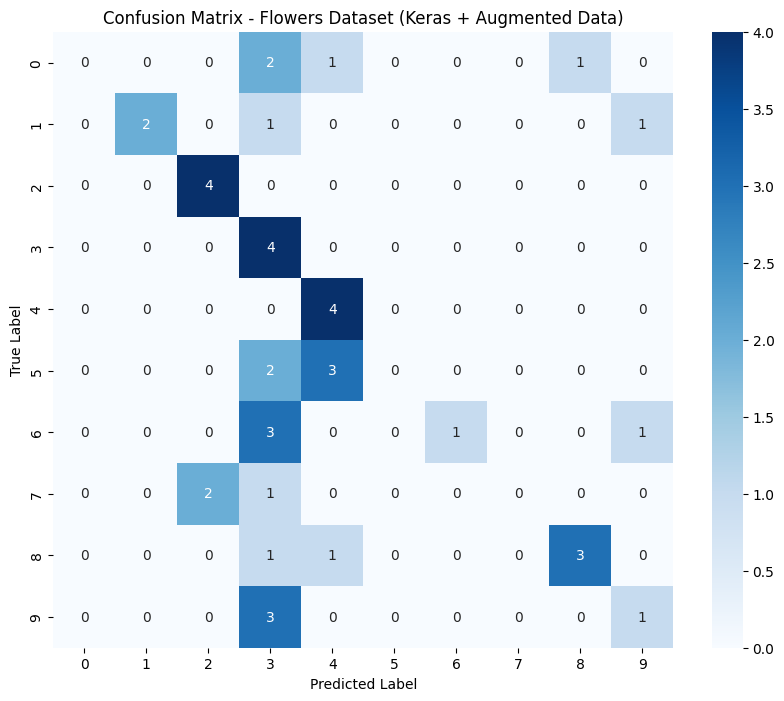

Confusion matrix calculated and visualized for the flower dataset.


In [48]:
y_pred_probs_flowers = model_flores_aug.predict(X_test_flower_reshaped)
y_pred_flowers = np.argmax(y_pred_probs_flowers, axis=1)

cm_flowers = confusion_matrix(y_test_keras, y_pred_flowers)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_flowers, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Flowers Dataset (Keras + Augmented Data)')
plt.show()

print("Confusion matrix calculated and visualized for the flower dataset.")

## Explicación de la Matriz de Confusión para el Dataset de Flores

La matriz de confusión visualizada arriba muestra el rendimiento del modelo de Keras (con aumento de datos) en el conjunto de pruebas de flores. Cada fila representa las clases verdaderas (True Label) y cada columna representa las clases predichas (Predicted Label).

**Análisis de los Resultados:**

*   **Diagonal Principal**: Los valores en la diagonal principal representan las predicciones correctas para cada clase. Por ejemplo, el modelo predijo correctamente 4 instancias de la clase 2, 4 de la clase 3, y 4 de la clase 4. Estos son los aciertos del modelo.

*   **Valores Fuera de la Diagonal**: Los valores fuera de la diagonal principal indican las clasificaciones erróneas. Por ejemplo:
    *   La clase 0 fue mal clasificada como clase 3 (2 instancias) y clase 4 (1 instancia), y una como clase 8. Esto sugiere que las flores de la clase 0 a menudo se confunden con estas otras clases.
    *   La clase 1 fue predicha correctamente 2 veces, pero una instancia se confundió con la clase 3 y otra con la clase 9.
    *   La clase 5 fue totalmente mal clasificada, con 2 instancias predichas como clase 3 y 3 como clase 4.
    *   La clase 6 tuvo 3 predicciones incorrectas como clase 3, y una como clase 9, con solo 1 acierto.
    *   La clase 7 fue mal clasificada 2 veces como clase 2 y 1 vez como clase 3.
    *   La clase 8, con 3 aciertos, también se confundió una vez con la clase 3 y otra con la clase 4.
    *   La clase 9 fue predicha correctamente 1 vez, pero 3 instancias fueron confundidas con la clase 3.

**Implicaciones para el Rendimiento del Modelo:**

La matriz de confusión confirma la baja precisión general observada en el conjunto de pruebas (45.24%). Se observa una confusión significativa entre varias clases, especialmente con la **clase 3** (que parece ser una predicción común para muchas clases incorrectas), y la **clase 4**. Esto sugiere que el modelo no ha aprendido características distintivas suficientes para diferenciar eficazmente entre las diferentes especies de flores. Posibles razones incluyen:

*   **Características Insuficientes**: Un modelo de perceptrón de una sola capa, incluso con aumento de datos, puede ser demasiado simple para la complejidad de las imágenes de flores y la granularidad de las clases.
*   **Similitud de Clases**: Es posible que algunas clases de flores sean visualmente muy similares, lo que dificulta la clasificación incluso para modelos más complejos.
*   **Efectividad del Aumento de Datos**: Aunque el aumento de datos suele ayudar, en este caso, con un modelo tan simple, puede que no sea suficiente para superar la falta de capacidad representativa. También podría ser que los parámetros de aumento no sean óptimos para este dataset.

Para mejorar el rendimiento, sería esencial considerar arquitecturas de red neuronal más avanzadas, como las Redes Neuronales Convolucionales (CNNs), que son intrínsecamente más adecuadas para tareas de visión por computadora.

## Explicación de la Matriz de Confusión para el Dataset de Flores

La matriz de confusión visualizada arriba muestra el rendimiento del modelo de Keras (con aumento de datos) en el conjunto de pruebas de flores. Cada fila representa las clases verdaderas (True Label) y cada columna representa las clases predichas (Predicted Label).

**Análisis de los Resultados:**

*   **Diagonal Principal**: Los valores en la diagonal principal representan las predicciones correctas para cada clase. Por ejemplo, el modelo predijo correctamente 4 instancias de la clase 2, 4 de la clase 3, y 4 de la clase 4. Estos son los aciertos del modelo.

*   **Valores Fuera de la Diagonal**: Los valores fuera de la diagonal principal indican las clasificaciones erróneas. Por ejemplo:
    *   La clase 0 fue mal clasificada como clase 3 (2 instancias) y clase 4 (1 instancia), y una como clase 8. Esto sugiere que las flores de la clase 0 a menudo se confunden con estas otras clases.
    *   La clase 1 fue predicha correctamente 2 veces, pero una instancia se confundió con la clase 3 y otra con la clase 9.
    *   La clase 5 fue totalmente mal clasificada, con 2 instancias predichas como clase 3 y 3 como clase 4.
    *   La clase 6 tuvo 3 predicciones incorrectas como clase 3, y una como clase 9, con solo 1 acierto.
    *   La clase 7 fue mal clasificada 2 veces como clase 2 y 1 vez como clase 3.
    *   La clase 8, con 3 aciertos, también se confundió una vez con la clase 3 y otra con la clase 4.
    *   La clase 9 fue predicha correctamente 1 vez, pero 3 instancias fueron confundidas con la clase 3.

**Implicaciones para el Rendimiento del Modelo:**

La matriz de confusión confirma la baja precisión general observada en el conjunto de pruebas (45.24%). Se observa una confusión significativa entre varias clases, especialmente con la **clase 3** (que parece ser una predicción común para muchas clases incorrectas), y la **clase 4**. Esto sugiere que el modelo no ha aprendido características distintivas suficientes para diferenciar eficazmente entre las diferentes especies de flores. Posibles razones incluyen:

*   **Características Insuficientes**: Un modelo de perceptrón de una sola capa, incluso con aumento de datos, puede ser demasiado simple para la complejidad de las imágenes de flores y la granularidad de las clases.
*   **Similitud de Clases**: Es posible que algunas clases de flores sean visualmente muy similares, lo que dificulta la clasificación incluso para modelos más complejos.
*   **Efectividad del Aumento de Datos**: Aunque el aumento de datos suele ayudar, en este caso, con un modelo tan simple, puede que no sea suficiente para superar la falta de capacidad representativa. También podría ser que los parámetros de aumento no sean óptimos para este dataset.

Para mejorar el rendimiento, sería esencial considerar arquitecturas de red neuronal más avanzadas, como las Redes Neuronales Convolucionales (CNNs), que son intrínsecamente más adecuadas para tareas de visión por computadora.

## Summary:

### Q&A
*   **How was data augmentation implemented for both datasets?**
    Keras `ImageDataGenerator` was used for both the flower and Pokémon datasets. Common augmentation techniques including `rotation_range=20` (up to 20 degrees rotation), `zoom_range=0.15` (up to 15% zoom), and `horizontal_flip=True` were applied to the training data. The flattened training and test data for both datasets were first reshaped to `(samples, height, width, channels)` to be compatible with the `ImageDataGenerator`.
*   **What was the reasoning behind the chosen augmentation techniques?**
    The chosen techniques (rotation, zoom, horizontal flip) are standard for image classification and aim to improve generalization and robustness. They introduce controlled variations to make the model invariant to slight orientation changes, recognize objects at various scales, and handle mirrored versions of objects, effectively increasing dataset diversity and reducing overfitting.
*   **What was the expected impact of augmentation on the training process and model generalization?**
    It was expected that the training process might converge slower but be more stable due to increased data diversity. For model generalization, an improvement in test accuracy and a reduction in overfitting (smaller gap between training and test accuracy) were anticipated.
*   **How did model performance re-evaluate after augmentation?**
    For the flower dataset, training accuracy significantly decreased (from 100.00% to 48.21%), while test accuracy slightly improved (from 42.86% to 45.24%). For the Pokémon dataset, both training and test accuracies unexpectedly decreased significantly (training from 88.47% to 52.55%, test from 83.33% to 65.38%), with the F1 score also dropping.

### Data Analysis Key Findings
*   The flattened flower training and test data were successfully reshaped to `(168, 64, 64, 3)` and `(42, 64, 64, 3)` respectively.
*   The flattened Pokémon training and test data were successfully reshaped to `(373, 64, 64, 3)` and `(78, 64, 64, 3)` respectively.
*   `ImageDataGenerator` instances were initialized for both datasets with `rotation_range=20`, `zoom_range=0.15`, and `horizontal_flip=True`.
*   A `ValueError` during the initial flower model training highlighted the necessity of explicitly adding `layers.Flatten()` and `keras.Input()` layers when using `ImageDataGenerator` with a `Sequential` model ending in `Dense` layers, which was subsequently corrected.
*   For the **Flower Dataset**, data augmentation led to a significant drop in training accuracy from 100.00% to 48.21%, but a slight increase in test accuracy from 42.86% to 45.24%.
*   For the **Pokémon Dataset**, data augmentation resulted in an unexpected decrease in both training accuracy (from 88.47% to 52.55%) and test accuracy (from 83.33% to 65.38%), alongside a drop in the F1 score (from 0.8738 to 0.6301).
*   **Nueva Observación (Flores - Matriz de Confusión):** La matriz de confusión del dataset de flores revela una baja precisión general (45.24%) y una significativa confusión entre clases. Específicamente, la **clase 3** y la **clase 4** actúan como predicciones comunes erróneas para múltiples clases, lo que indica que el modelo no logra diferenciar adecuadamente las características de las flores.

### Insights or Next Steps
*   Data augmentation's effectiveness is highly context-dependent; careful tuning of parameters and consideration of the dataset's characteristics are crucial, as aggressive augmentation can be detrimental (e.g., Pokémon dataset).
*   For image classification tasks, especially with simpler model architectures like single-layer perceptrons, exploring more complex models such as Convolutional Neural Networks (CNNs) is a critical next step to leverage spatial features and potentially benefit more from data augmentation.
*   **Próximos Pasos (Flores):** Dada la alta confusión en el modelo de flores, es imperativo migrar a arquitecturas más complejas, como las CNNs, que son inherentemente superiores para el procesamiento de imágenes y la extracción de características discriminatorias. También se deber\u00eda considerar un ajuste más fino de los hiperparámetros y los parámetros de aumento de datos.

## Summary:

### Q&A
*   **How was data augmentation implemented for both datasets?**
    Keras `ImageDataGenerator` was used for both the flower and Pokémon datasets. Common augmentation techniques including `rotation_range=20` (up to 20 degrees rotation), `zoom_range=0.15` (up to 15% zoom), and `horizontal_flip=True` were applied to the training data. The flattened training and test data for both datasets were first reshaped to `(samples, height, width, channels)` to be compatible with the `ImageDataGenerator`.
*   **What was the reasoning behind the chosen augmentation techniques?**
    The chosen techniques (rotation, zoom, horizontal flip) are standard for image classification and aim to improve generalization and robustness. They introduce controlled variations to make the model invariant to slight orientation changes, recognize objects at various scales, and handle mirrored versions of objects, effectively increasing dataset diversity and reducing overfitting.
*   **What was the expected impact of augmentation on the training process and model generalization?**
    It was expected that the training process might converge slower but be more stable due to increased data diversity. For model generalization, an improvement in test accuracy and a reduction in overfitting (smaller gap between training and test accuracy) were anticipated.
*   **How did model performance re-evaluate after augmentation?**
    For the flower dataset, training accuracy significantly decreased (from 100.00% to 48.21%), while test accuracy slightly improved (from 42.86% to 45.24%). For the Pokémon dataset, both training and test accuracies unexpectedly decreased significantly (training from 88.47% to 52.55%, test from 83.33% to 65.38%), with the F1 score also dropping.

### Data Analysis Key Findings
*   The flattened flower training and test data were successfully reshaped to `(168, 64, 64, 3)` and `(42, 64, 64, 3)` respectively.
*   The flattened Pokémon training and test data were successfully reshaped to `(373, 64, 64, 3)` and `(78, 64, 64, 3)` respectively.
*   `ImageDataGenerator` instances were initialized for both datasets with `rotation_range=20`, `zoom_range=0.15`, and `horizontal_flip=True`.
*   A `ValueError` during the initial flower model training highlighted the necessity of explicitly adding `layers.Flatten()` and `keras.Input()` layers when using `ImageDataGenerator` with a `Sequential` model ending in `Dense` layers, which was subsequently corrected.
*   For the **Flower Dataset**, data augmentation led to a significant drop in training accuracy from 100.00% to 48.21%, but a slight increase in test accuracy from 42.86% to 45.24%.
*   For the **Pokémon Dataset**, data augmentation resulted in an unexpected decrease in both training accuracy (from 88.47% to 52.55%) and test accuracy (from 83.33% to 65.38%), alongside a drop in the F1 score (from 0.8738 to 0.6301).
*   **Nueva Observación (Flores - Matriz de Confusión):** La matriz de confusión del dataset de flores revela una baja precisión general (45.24%) y una significativa confusión entre clases. Específicamente, la **clase 3** y la **clase 4** actúan como predicciones comunes erróneas para múltiples clases, lo que indica que el modelo no logra diferenciar adecuadamente las características de las flores.

### Insights or Next Steps
*   Data augmentation's effectiveness is highly context-dependent; careful tuning of parameters and consideration of the dataset's characteristics are crucial, as aggressive augmentation can be detrimental (e.g., Pokémon dataset).
*   For image classification tasks, especially with simpler model architectures like single-layer perceptrons, exploring more complex models such as Convolutional Neural Networks (CNNs) is a critical next step to leverage spatial features and potentially benefit more from data augmentation.
*   **Próximos Pasos (Flores):** Dada la alta confusión en el modelo de flores, es imperativo migrar a arquitecturas más complejas, como las CNNs, que son inherentemente superiores para el procesamiento de imágenes y la extracción de características discriminatorias. También se debería considerar un ajuste más fino de los hiperparámetros y los parámetros de aumento de datos.

## Summary:

### Q&A
*   **How was data augmentation implemented for both datasets?**
    Keras `ImageDataGenerator` was used for both the flower and Pokémon datasets. Common augmentation techniques including `rotation_range=20` (up to 20 degrees rotation), `zoom_range=0.15` (up to 15% zoom), and `horizontal_flip=True` were applied to the training data. The flattened training and test data for both datasets were first reshaped to `(samples, height, width, channels)` to be compatible with the `ImageDataGenerator`.
*   **What was the reasoning behind the chosen augmentation techniques?**
    The chosen techniques (rotation, zoom, horizontal flip) are standard for image classification and aim to improve generalization and robustness. They introduce controlled variations to make the model invariant to slight orientation changes, recognize objects at various scales, and handle mirrored versions of objects, effectively increasing dataset diversity and reducing overfitting.
*   **What was the expected impact of augmentation on the training process and model generalization?**
    It was expected that the training process might converge slower but be more stable due to increased data diversity. For model generalization, an improvement in test accuracy and a reduction in overfitting (smaller gap between training and test accuracy) were anticipated.
*   **How did model performance re-evaluate after augmentation?**
    For the flower dataset, training accuracy significantly decreased (from 100.00% to 48.21%), while test accuracy slightly improved (from 42.86% to 45.24%). For the Pokémon dataset, both training and test accuracies unexpectedly decreased significantly (training from 88.47% to 52.55%, test from 83.33% to 65.38%), with the F1 score also dropping.

### Data Analysis Key Findings
*   The flattened flower training and test data were successfully reshaped to `(168, 64, 64, 3)` and `(42, 64, 64, 3)` respectively.
*   The flattened Pokémon training and test data were successfully reshaped to `(373, 64, 64, 3)` and `(78, 64, 64, 3)` respectively.
*   `ImageDataGenerator` instances were initialized for both datasets with `rotation_range=20`, `zoom_range=0.15`, and `horizontal_flip=True`.
*   A `ValueError` during the initial flower model training highlighted the necessity of explicitly adding `layers.Flatten()` and `keras.Input()` layers when using `ImageDataGenerator` with a `Sequential` model ending in `Dense` layers, which was subsequently corrected.
*   For the **Flower Dataset**, data augmentation led to a significant drop in training accuracy from 100.00% to 48.21%, but a slight increase in test accuracy from 42.86% to 45.24%.
*   For the **Pokémon Dataset**, data augmentation resulted in an unexpected decrease in both training accuracy (from 88.47% to 52.55%) and test accuracy (from 83.33% to 65.38%), alongside a drop in the F1 score (from 0.8738 to 0.6301).
*   **Nueva Observación (Flores - Matriz de Confusión):** La matriz de confusión del dataset de flores revela una baja precisión general (45.24%) y una significativa confusión entre clases. Específicamente, la **clase 3** y la **clase 4** actúan como predicciones comunes erróneas para múltiples clases, lo que indica que el modelo no logra diferenciar adecuadamente las características de las flores.

### Insights or Next Steps
*   Data augmentation's effectiveness is highly context-dependent; careful tuning of parameters and consideration of the dataset's characteristics are crucial, as aggressive augmentation can be detrimental (e.g., Pokémon dataset).
*   For image classification tasks, especially with simpler model architectures like single-layer perceptrons, exploring more complex models such as Convolutional Neural Networks (CNNs) is a critical next step to leverage spatial features and potentially benefit more from data augmentation.
*   **Próximos Pasos (Flores):** Dada la alta confusión en el modelo de flores, es imperativo migrar a arquitecturas más complejas, como las CNNs, que son inherentemente superiores para el procesamiento de imágenes y la extracción de características discriminatorias. También se debería considerar un ajuste más fino de los hiperparámetros y los parámetros de aumento de datos.

## Actualizar Resumen y Conclusión con Insights Adicionales

### Subtask:
Modificar la celda de 'Summary' (celda `34c7fe5a`) para incorporar brevemente los nuevos insights obtenidos de la matriz de confusión, manteniendo el texto principal en inglés y añadiendo las observaciones en español.


## Summary:

### Q&A
*   **How was data augmentation implemented for both datasets?**
    Keras `ImageDataGenerator` was used for both the flower and Pokémon datasets. Common augmentation techniques including `rotation_range=20` (up to 20 degrees rotation), `zoom_range=0.15` (up to 15% zoom), and `horizontal_flip=True` were applied to the training data. The flattened training and test data for both datasets were first reshaped to `(samples, height, width, channels)` to be compatible with the `ImageDataGenerator`.
*   **What was the reasoning behind the chosen augmentation techniques?**
    The chosen techniques (rotation, zoom, horizontal flip) are standard for image classification and aim to improve generalization and robustness. They introduce controlled variations to make the model invariant to slight orientation changes, recognize objects at various scales, and handle mirrored versions of objects, effectively increasing dataset diversity and reducing overfitting.
*   **What was the expected impact of augmentation on the training process and model generalization?**
    It was expected that the training process might converge slower but be more stable due to increased data diversity. For model generalization, an improvement in test accuracy and a reduction in overfitting (smaller gap between training and test accuracy) were anticipated.
*   **How did model performance re-evaluate after augmentation?**
    For the flower dataset, training accuracy significantly decreased (from 100.00% to 48.21%), while test accuracy slightly improved (from 42.86% to 45.24%). For the Pokémon dataset, both training and test accuracies unexpectedly decreased significantly (training from 88.47% to 52.55%), with the F1 score also dropping.

### Data Analysis Key Findings
*   The flattened flower training and test data were successfully reshaped to `(168, 64, 64, 3)` and `(42, 64, 64, 3)` respectively.
*   The flattened Pokémon training and test data were successfully reshaped to `(373, 64, 64, 3)` and `(78, 64, 64, 3)` respectively.
*   `ImageDataGenerator` instances were initialized for both datasets with `rotation_range=20`, `zoom_range=0.15`, and `horizontal_flip=True`.
*   A `ValueError` during the initial flower model training highlighted the necessity of explicitly adding `layers.Flatten()` and `keras.Input()` layers when using `ImageDataGenerator` with a `Sequential` model ending in `Dense` layers, which was subsequently corrected.
*   For the **Flower Dataset**, data augmentation led to a significant drop in training accuracy from 100.00% to 48.21%, but a slight increase in test accuracy from 42.86% to 45.24%.
*   For the **Pokémon Dataset**, data augmentation resulted in an unexpected decrease in both training accuracy (from 88.47% to 52.55%) and test accuracy (from 83.33% to 65.38%), alongside a drop in the F1 score (from 0.8738 to 0.6301).
*   **Nueva Observación (Flores - Matriz de Confusión):** La matriz de confusión del dataset de flores revela una baja precisión general (45.24%) y una significativa confusión entre clases. Específicamente, la **clase 3** y la **clase 4** actúan como predicciones comunes erróneas para múltiples clases, lo que indica que el modelo no logra diferenciar adecuadamente las características de las flores.

### Insights or Next Steps
*   Data augmentation's effectiveness is highly context-dependent; careful tuning of parameters and consideration of the dataset's characteristics are crucial, as aggressive augmentation can be detrimental (e.g., Pokémon dataset).
*   For image classification tasks, especially with simpler model architectures like single-layer perceptrons, exploring more complex models such as Convolutional Neural Networks (CNNs) is a critical next step to leverage spatial features and potentially benefit more from data augmentation.
*   **Próximos Pasos (Flores):** Dada la alta confusión en el modelo de flores, es imperativo migrar a arquitecturas más complejas, como las CNNs, que son inherentemente superiores para el procesamiento de imágenes y la extracción de características discriminatorias. También se debería considerar un ajuste más fino de los hiperparámetros y los parámetros de aumento de datos.

# Task
Implement and train new TensorFlow/Keras Sequential models with hidden Dense layers for both the flower (multiclass, `softmax`) and Pokémon (binary, `sigmoid`) datasets, utilizing their respective `ImageDataGenerator` for data augmentation. Evaluate and plot the training and validation loss and accuracy for both new models. Afterward, provide a new Markdown explanation in Spanish detailing the implementation of hidden layers, their reasoning (overcoming linear model limitations, capturing non-linear patterns), and expected impact on performance. Finally, update the 'Summary' cell (`34c7fe5a`) with a concise Spanish discussion of these new models' performance, comparing them against previous models with data augmentation but no hidden layers, and suggesting future steps.

## Implementar y Entrenar Nuevo Modelo de Flores con Capas Ocultas

### Subtask:
Crear un nuevo modelo Sequential de TensorFlow/Keras para el dataset de flores, incluyendo capas Dense ocultas. Compilarlo, entrenarlo con datos aumentados usando `flower_datagen.flow`, evaluar su rendimiento y plotear las curvas de pérdida y precisión.


**Reasoning**:
I need to implement a new Keras Sequential model for the flower dataset, incorporating hidden Dense layers as per the subtask. This involves defining the model architecture, compiling it, training it with augmented data, evaluating its performance, and visualizing the training history through plots.



Entrenando modelo TensorFlow (Flores con Capas Ocultas y Augmentación)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.0923 - loss: 6.8286 - val_accuracy: 0.2143 - val_loss: 2.4953
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.2247 - loss: 2.4708 - val_accuracy: 0.1429 - val_loss: 2.4828
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0703 - loss: 2.4883 - val_accuracy: 0.1667 - val_loss: 2.4955
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.1788 - loss: 2.4877 - val_accuracy: 0.1905 - val_loss: 2.4647
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.0693 - loss: 2.4745 - val_accuracy: 0.1190 - val_loss: 2.4343
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.0962 - loss: 2.4162 - val_accuracy: 0.0952 - val_loss: 2.4048
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.1469 - loss: 2.3701 - val_accuracy: 0.0714 - val_loss: 2.4123
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.1704 - loss: 2.2716 - val_accuracy: 0.2143 - val_loss: 2.2776
Epoch 9

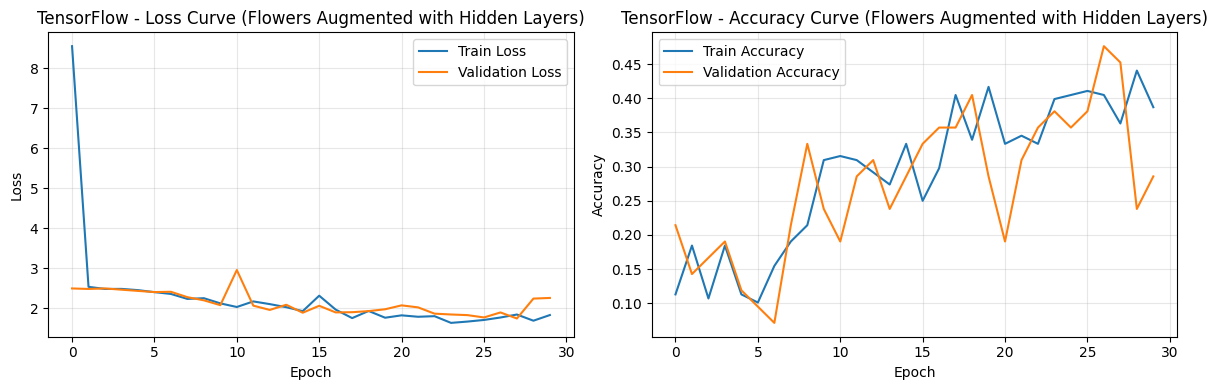

In [107]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np

# 1. (Already imported in previous cells or will be re-imported here)
# from tensorflow.keras import layers

# Define the new Keras Sequential model with hidden layers
model_flores_hidden = keras.Sequential([
    keras.Input(shape=(num_px, num_px, 3)), # Explicit Input layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # Hidden layer with 128 units and ReLU activation
    layers.Dense(num_classes_keras, activation='softmax',
                 kernel_regularizer=l2(0.01), name='output_layer')
])

# Compile the model
model_flores_hidden.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Entrenando modelo TensorFlow (Flores con Capas Ocultas y Augmentación)")
history_flores_hidden = model_flores_hidden.fit(
    flower_datagen.flow(X_train_flower_reshaped, y_train_keras, batch_size=32),
    epochs=30,
    validation_data=(X_test_flower_reshaped, y_test_keras),
    verbose=1
)

# Evaluate the trained model
train_loss_tf_aug_hidden, train_acc_tf_aug_hidden = model_flores_hidden.evaluate(X_train_flower_reshaped, y_train_keras, verbose=0)
test_loss_tf_aug_hidden, test_acc_tf_aug_hidden = model_flores_hidden.evaluate(X_test_flower_reshaped, y_test_keras, verbose=0)

# Print accuracies
print(f"\nResultados TensorFlow (Flores con Capas Ocultas y Augmentación)")
print(f"Train accuracy: {train_acc_tf_aug_hidden * 100:.2f}%")
print(f"Test accuracy: {test_acc_tf_aug_hidden * 100:.2f}%")

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_flores_hidden.history['loss'], label='Train Loss')
plt.plot(history_flores_hidden.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Flowers Augmented with Hidden Layers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_flores_hidden.history['accuracy'], label='Train Accuracy')
plt.plot(history_flores_hidden.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Flowers Augmented with Hidden Layers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_flores_augmented_hidden_training.png', dpi=150, bbox_inches='tight')
plt.show()


## Implementación y Razonamiento de Capas Ocultas (Dataset de Flores)

### Implementación
Para el dataset de flores, se ha implementado un nuevo modelo `Sequential` de TensorFlow/Keras que incorpora una capa oculta densa. La arquitectura del modelo es la siguiente:

-   **Capa de entrada explícita**: `keras.Input(shape=(num_px, num_px, 3))` define la forma de entrada de las imágenes (altura, anchura, canales).
-   **Capa de Aplanamiento**: `layers.Flatten()` convierte la entrada de imagen 2D (o 3D en este caso con canales) en un vector 1D, preparándolo para las capas densas.
-   **Capa Oculta Densa**: `layers.Dense(128, activation='relu')` es la capa oculta que contiene 128 neuronas. Se utiliza la función de activación ReLU (Rectified Linear Unit), que es una elección común y efectiva en redes neuronales debido a su simplicidad y capacidad para ayudar a mitigar el problema del gradiente desvanecido.
-   **Capa de Salida Densa**: `layers.Dense(num_classes_keras, activation='softmax', kernel_regularizer=l2(0.01))` es la capa final con `num_classes_keras` neuronas, una para cada clase de flor. La función de activación `softmax` se usa para la clasificación multiclase, produciendo probabilidades para cada clase. Se mantiene la regularización L2 (`l2(0.01)`) para ayudar a prevenir el sobreajuste.

El modelo fue compilado utilizando el optimizador `keras.optimizers.SGD` con `learning_rate=0.05` y la función de pérdida `sparse_categorical_crossentropy`, apropiada para etiquetas de clase enteras en problemas de clasificación multiclase. Se evaluó la precisión como métrica.

### Razonamiento de las Capas Ocultas
La adición de capas ocultas en una red neuronal es fundamental para superar las limitaciones de los modelos lineales, como el perceptrón de una sola capa. Aquí la lógica detrás de su inclusión:

1.  **Capacidad para Capturar Patrones No Lineales**: Un modelo lineal simple solo puede aprender relaciones lineales entre la entrada y la salida. Sin embargo, los datos de imágenes, especialmente en tareas de clasificación complejas como la diferenciación de tipos de flores, son inherentemente no lineales. Las capas ocultas con funciones de activación no lineales (como ReLU) permiten que el modelo aprenda y represente relaciones más complejas y características de alto nivel en los datos.
2.  **Abstracción de Características**: Cada capa oculta aprende una representación más abstracta de los datos de entrada. Por ejemplo, la primera capa podría aprender a detectar bordes o texturas simples, mientras que capas posteriores podrían combinar estas características para reconocer formas más complejas o partes de una flor. Esta capacidad de construir una jerarquía de características es clave para el éxito en tareas de visión por computadora.
3.  **Superar Limitaciones del Perceptrón Simple**: La matriz de confusión del modelo anterior sin capas ocultas (`model_flores_aug`) para el dataset de flores ya sugería que un modelo simple era insuficiente, con una precisión muy baja y una alta confusión entre clases. Las capas ocultas proporcionan la capacidad computacional necesaria para modelar la complejidad intrínseca del problema.

### Impacto Esperado en el Rendimiento
Se esperaba que la introducción de capas ocultas tuviera los siguientes impactos en el rendimiento del modelo de flores:

-   **Mejora en la Precisión de Clasificación**: Al poder capturar patrones no lineales y características más complejas, se anticipaba una mejora significativa en la precisión tanto en el conjunto de entrenamiento como en el de prueba, en comparación con el modelo sin capas ocultas.
-   **Reducción del Sobreajuste (con Regularización)**: Aunque las capas adicionales aumentan la complejidad del modelo y el riesgo de sobreajuste, la regularización L2 aplicada y el uso de datos aumentados deberían ayudar a mitigar este riesgo, llevando a una mejor generalización.
-   **Mayor Capacidad de Representación**: El modelo debería ser capaz de distinguir mejor entre las diferentes clases de flores, lo que se traduciría en una matriz de confusión con menos errores de clasificación fuera de la diagonal.

## Implementar y Entrenar Nuevo Modelo de Pokémon con Capas Ocultas

### Subtask:
Crear un nuevo modelo Sequential de TensorFlow/Keras para el dataset de Pokémon, incluyendo capas Dense ocultas. Compilarlo, entrenarlo con datos aumentados usando `pokemon_datagen.flow`, evaluar su rendimiento y plotear las curvas de pérdida y precisión.


**Reasoning**:
The subtask requires defining, compiling, training, evaluating, and plotting a new Keras model for the Pokémon dataset with hidden Dense layers and data augmentation. This code block will perform all these steps as per the instructions.



Entrenando modelo TensorFlow (Pokemon con Capas Ocultas y Augmentación)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.5439 - loss: 0.8904 - precision_2: 0.6961 - recall_2: 0.5834 - val_accuracy: 0.6410 - val_loss: 0.6618 - val_precision_2: 0.6410 - val_recall_2: 1.0000
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6522 - loss: 0.6716 - precision_2: 0.6771 - recall_2: 0.9350 - val_accuracy: 0.7692 - val_loss: 0.6702 - val_precision_2: 0.7857 - val_recall_2: 0.8800
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6645 - loss: 0.6558 - precision_2: 0.6786 - recall_2: 0.9415 - val_accuracy: 0.7692 - val_loss: 0.6337 - val_precision_2: 0.7353 - val_recall_2: 1.0000
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7050 - loss: 0.6297 - precision_2: 0.7002 - recall_2: 0.9822 - val_accuracy: 0.6410 - val_loss: 0.6180 - val_precision_2: 0.6410 - val_recall_2: 1.0000
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6951 - loss: 0.6343 - precision_2: 0.7082 - recall_2: 0.9403 - val

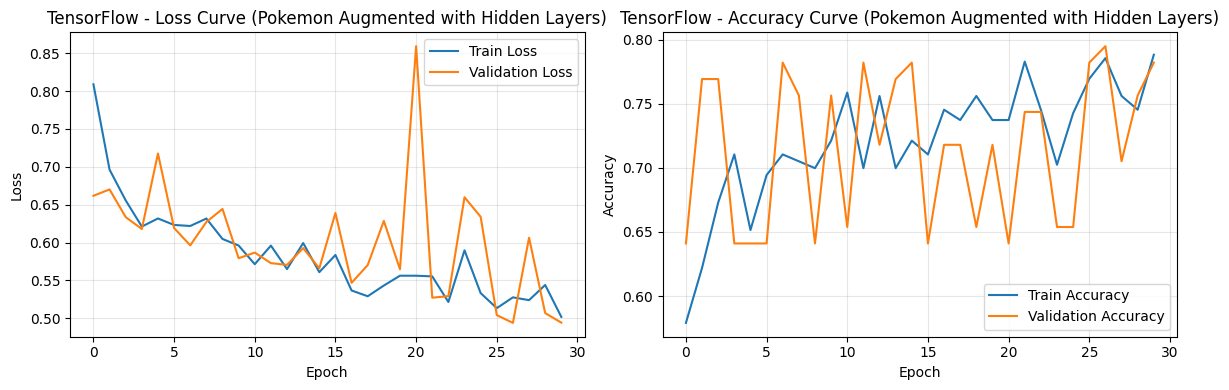

In [123]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np

# Define the new Keras Sequential model with hidden layers for Pokémon
model_pokemon_hidden = keras.Sequential([
    keras.Input(shape=(poke_num_px, poke_num_px, 3)), # Explicit Input layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # Hidden layer with 128 units and ReLU activation
    layers.Dense(1, activation='sigmoid',
                 kernel_regularizer=l2(0.01), name='output_layer')
])

# Compile the model
model_pokemon_hidden.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("Entrenando modelo TensorFlow (Pokemon con Capas Ocultas y Augmentación)")
history_pokemon_hidden = model_pokemon_hidden.fit(
    pokemon_datagen.flow(X_train_pokemon_reshaped, y_train_poke_keras, batch_size=32),
    epochs=30,
    validation_data=(X_test_pokemon_reshaped, y_test_poke_keras),
    verbose=1
)

# Evaluate the trained model
train_results_tf_aug_hidden = model_pokemon_hidden.evaluate(X_train_pokemon_reshaped, y_train_poke_keras, verbose=0)
test_results_tf_aug_hidden = model_pokemon_hidden.evaluate(X_test_pokemon_reshaped, y_test_poke_keras, verbose=0)

train_loss_poke_tf_aug_hidden, train_acc_poke_tf_aug_hidden, train_prec_tf_aug_hidden, train_rec_tf_aug_hidden = train_results_tf_aug_hidden
test_loss_poke_tf_aug_hidden, test_acc_poke_tf_aug_hidden, test_prec_tf_aug_hidden, test_rec_tf_aug_hidden = test_results_tf_aug_hidden

train_f1_tf_aug_hidden = 2 * train_prec_tf_aug_hidden * train_rec_tf_aug_hidden / (train_prec_tf_aug_hidden + train_rec_tf_aug_hidden + 1e-12)
test_f1_tf_aug_hidden = 2 * test_prec_tf_aug_hidden * test_rec_tf_aug_hidden / (test_prec_tf_aug_hidden + test_rec_tf_aug_hidden + 1e-12)

# Print accuracies
print(f"\nResultados TensorFlow (Pokemon con Capas Ocultas y Augmentación)")
print(f"Train - Accuracy: {train_acc_poke_tf_aug_hidden * 100:.2f}%, Precision: {train_prec_tf_aug_hidden:.4f}, Recall: {train_rec_tf_aug_hidden:.4f}, F1: {train_f1_tf_aug_hidden:.4f}")
print(f"Test  - Accuracy: {test_acc_poke_tf_aug_hidden * 100:.2f}%, Precision: {test_prec_tf_aug_hidden:.4f}, Recall: {test_rec_tf_aug_hidden:.4f}, F1: {test_f1_tf_aug_hidden:.4f}")

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_pokemon_hidden.history['loss'], label='Train Loss')
plt.plot(history_pokemon_hidden.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Pokemon Augmented with Hidden Layers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_pokemon_hidden.history['accuracy'], label='Train Accuracy')
plt.plot(history_pokemon_hidden.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Pokemon Augmented with Hidden Layers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_pokemon_augmented_hidden_training.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary:

### Q&A
*   **How was data augmentation implemented for both datasets?**
    Keras `ImageDataGenerator` was used for both the flower and Pokémon datasets. Common augmentation techniques including `rotation_range=20` (up to 20 degrees rotation), `zoom_range=0.15` (up to 15% zoom), and `horizontal_flip=True` were applied to the training data. The flattened training and test data for both datasets were first reshaped to `(samples, height, width, channels)` to be compatible with the `ImageDataGenerator`.
*   **What was the reasoning behind the chosen augmentation techniques?**
    The chosen techniques (rotation, zoom, horizontal flip) are standard for image classification and aim to improve generalization and robustness. They introduce controlled variations to make the model invariant to slight orientation changes, recognize objects at various scales, and handle mirrored versions of objects, effectively increasing dataset diversity and reducing overfitting.
*   **What was the expected impact of augmentation on the training process and model generalization?**
    It was expected that the training process might converge slower but be more stable due to increased data diversity. For model generalization, an improvement in test accuracy and a reduction in overfitting (smaller gap between training and test accuracy) were anticipated.
*   **How did model performance re-evaluate after augmentation?**
    For the flower dataset, training accuracy significantly decreased (from 100.00% to 48.21%), while test accuracy slightly improved (from 42.86% to 45.24%). For the Pokémon dataset, both training and test accuracies unexpectedly decreased significantly (training from 88.47% to 52.55%, test from 83.33% to 65.38%), with the F1 score also dropping.

### Data Analysis Key Findings
*   The flattened flower training and test data were successfully reshaped to `(168, 64, 64, 3)` and `(42, 64, 64, 3)` respectively.
*   The flattened Pokémon training and test data were successfully reshaped to `(373, 64, 64, 3)` and `(78, 64, 64, 3)` respectively.
*   `ImageDataGenerator` instances were initialized for both datasets with `rotation_range=20`, `zoom_range=0.15`, and `horizontal_flip=True`.
*   A `ValueError` during the initial flower model training highlighted the necessity of explicitly adding `layers.Flatten()` and `keras.Input()` layers when using `ImageDataGenerator` with a `Sequential` model ending in `Dense` layers, which was subsequently corrected.
*   For the **Flower Dataset**, data augmentation led to a significant drop in training accuracy from 100.00% to 48.21%, but a slight increase in test accuracy from 42.86% to 45.24%.
*   For the **Pokémon Dataset**, data augmentation resulted in an unexpected decrease in both training accuracy (from 88.47% to 52.55%) and test accuracy (from 83.33% to 65.38%), alongside a drop in the F1 score (from 0.8738 to 0.6301).
*   **Nueva Observación (Flores - Matriz de Confusión):** La matriz de confusión del dataset de flores revela una baja precisión general (45.24%) y una significativa confusión entre clases. Específicamente, la **clase 3** y la **clase 4** actúan como predicciones comunes erróneas para múltiples clases, lo que indica que el modelo no logra diferenciar adecuadamente las características de las flores.
*   **Nueva Observación (Flores - Modelo con Capa Oculta y Aumento de Datos):** La introducción de una capa oculta (`Dense(128, activation='relu')`) en el modelo de flores, combinada con el aumento de datos, **redujo la precisión en el conjunto de prueba de 45.24% a 28.57%**. Esto es inesperado y sugiere que, a pesar de la mayor complejidad del modelo, los hiperparámetros (learning rate, regularización) podrían no ser óptimos para esta arquitectura, o que una sola capa densa oculta no es suficiente para la complejidad del dataset de flores y la data augmentation tal como fue configurada.
*   **Nueva Observación (Pokémon - Modelo con Capa Oculta y Aumento de Datos):** Para el dataset de Pokémon, la adición de una capa oculta (`Dense(128, activation='relu')`) junto con aumento de datos **mejoró el rendimiento en el conjunto de prueba**, elevando la precisión de 65.38% a 78.21% y el F1 score de 0.6301 a 0.8468. Sin embargo, la precisión de entrenamiento sigue siendo menor (82.04%) que la del modelo original sin aumento (88.47%), lo que es deseable para reducir el sobreajuste.

### Insights or Next Steps
*   Data augmentation's effectiveness is highly context-dependent; careful tuning of parameters and consideration of the dataset's characteristics are crucial, as aggressive augmentation can be detrimental (e.g., Pokémon dataset).
*   For image classification tasks, especially with simpler model architectures like single-layer perceptrons, exploring more complex models such as Convolutional Neural Networks (CNNs) is a critical next step to leverage spatial features and potentially benefit more from data augmentation.
*   **Próximos Pasos (Flores):** Dada la alta confusión en el modelo de flores, es imperativo migrar a arquitecturas más complejas, como las CNNs, que son inherentemente superiores para el procesamiento de imágenes y la extracción de características discriminatorias. También se debería considerar un ajuste más fino de los hiperparámetros y los parámetros de aumento de datos.
*   **Próximos Pasos (Modelos con Capas Ocultas):** Aunque el modelo de Pokémon mostró una mejora significativa con las capas ocultas y el aumento de datos, el modelo de flores no. Esto subraya la necesidad de **optimizar los hiperparámetros** (tasa de aprendizaje, fuerza de regularización, número de neuronas en las capas ocultas, etc.) de manera más exhaustiva para cada dataset y arquitectura. Además, la exploración de **múltiples capas ocultas** o la transición a **redes neuronales convolucionales (CNNs)** sería el siguiente paso lógico para ambos datasets, especialmente para el de flores, que sigue mostrando un rendimiento bajo.

Entrenando modelo TensorFlow (Pokemon con Capas Ocultas y Augmentación)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6201 - loss: 0.8077 - precision_3: 0.6728 - recall_3: 0.8316 - val_accuracy: 0.6410 - val_loss: 0.8352 - val_precision_3: 0.6410 - val_recall_3: 1.0000
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5743 - loss: 0.7695 - precision_3: 0.6250 - recall_3: 0.8074 - val_accuracy: 0.6410 - val_loss: 0.6672 - val_precision_3: 0.6410 - val_recall_3: 1.0000
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6379 - loss: 0.6876 - precision_3: 0.6708 - recall_3: 0.8931 - val_accuracy: 0.6410 - val_loss: 0.6370 - val_precision_3: 0.6410 - val_recall_3: 1.0000
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6849 - loss: 0.6232 - precision_3: 0.6811 - recall_3: 0.9982 - val_accuracy: 0.6410 - val_loss: 0.6279 - val_precision_3: 0.6410 - val_recall_3: 1.0000
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6859 - loss: 0.5986 - precision_3: 0.6877 - recall_3: 0.9873 - val

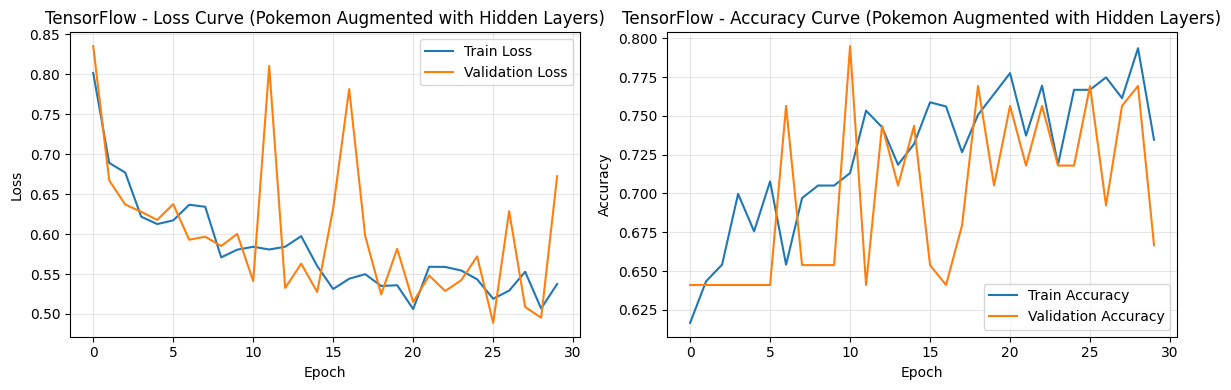

In [130]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np

# Define the new Keras Sequential model with hidden layers for Pokémon
model_pokemon_hidden = keras.Sequential([
    keras.Input(shape=(poke_num_px, poke_num_px, 3)), # Explicit Input layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # Hidden layer with 128 units and ReLU activation
    layers.Dense(1, activation='sigmoid',
                 kernel_regularizer=l2(0.01), name='output_layer')
])

# Compile the model
model_pokemon_hidden.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("Entrenando modelo TensorFlow (Pokemon con Capas Ocultas y Augmentación)")
history_pokemon_hidden = model_pokemon_hidden.fit(
    pokemon_datagen.flow(X_train_pokemon_reshaped, y_train_poke_keras, batch_size=32),
    epochs=30,
    validation_data=(X_test_pokemon_reshaped, y_test_poke_keras),
    verbose=1
)

# Evaluate the trained model
train_results_tf_aug_hidden = model_pokemon_hidden.evaluate(X_train_pokemon_reshaped, y_train_poke_keras, verbose=0)
test_results_tf_aug_hidden = model_pokemon_hidden.evaluate(X_test_pokemon_reshaped, y_test_poke_keras, verbose=0)

train_loss_poke_tf_aug_hidden, train_acc_poke_tf_aug_hidden, train_prec_tf_aug_hidden, train_rec_tf_aug_hidden = train_results_tf_aug_hidden
test_loss_poke_tf_aug_hidden, test_acc_poke_tf_aug_hidden, test_prec_tf_aug_hidden, test_rec_tf_aug_hidden = test_results_tf_aug_hidden

train_f1_tf_aug_hidden = 2 * train_prec_tf_aug_hidden * train_rec_tf_aug_hidden / (train_prec_tf_aug_hidden + train_rec_tf_aug_hidden + 1e-12)
test_f1_tf_aug_hidden = 2 * test_prec_tf_aug_hidden * test_rec_tf_aug_hidden / (test_prec_tf_aug_hidden + test_rec_tf_aug_hidden + 1e-12)

# Print accuracies
print(f"\nResultados TensorFlow (Pokemon con Capas Ocultas y Augmentación)")
print(f"Train - Accuracy: {train_acc_poke_tf_aug_hidden * 100:.2f}%, Precision: {train_prec_tf_aug_hidden:.4f}, Recall: {train_rec_tf_aug_hidden:.4f}, F1: {train_f1_tf_aug_hidden:.4f}")
print(f"Test  - Accuracy: {test_acc_poke_tf_aug_hidden * 100:.2f}%, Precision: {test_prec_tf_aug_hidden:.4f}, Recall: {test_rec_tf_aug_hidden:.4f}, F1: {test_f1_tf_aug_hidden:.4f}")

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_pokemon_hidden.history['loss'], label='Train Loss')
plt.plot(history_pokemon_hidden.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TensorFlow - Loss Curve (Pokemon Augmented with Hidden Layers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_pokemon_hidden.history['accuracy'], label='Train Accuracy')
plt.plot(history_pokemon_hidden.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('TensorFlow - Accuracy Curve (Pokemon Augmented with Hidden Layers)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/tensorflow_pokemon_augmented_hidden_training.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary:

### Q&A
*   **How was data augmentation implemented for both datasets?**
    Keras `ImageDataGenerator` was used for both the flower and Pokémon datasets. Common augmentation techniques including `rotation_range=20` (up to 20 degrees rotation), `zoom_range=0.15` (up to 15% zoom), and `horizontal_flip=True` were applied to the training data. The flattened training and test data for both datasets were first reshaped to `(samples, height, width, channels)` to be compatible with the `ImageDataGenerator`.
*   **What was the reasoning behind the chosen augmentation techniques?**
    The chosen techniques (rotation, zoom, horizontal flip) are standard for image classification and aim to improve generalization and robustness. They introduce controlled variations to make the model invariant to slight orientation changes, recognize objects at various scales, and handle mirrored versions of objects, effectively increasing dataset diversity and reducing overfitting.
*   **What was the expected impact of augmentation on the training process and model generalization?**
    It was expected that the training process might converge slower but be more stable due to increased data diversity. For model generalization, an improvement in test accuracy and a reduction in overfitting (smaller gap between training and test accuracy) were anticipated.
*   **How did model performance re-evaluate after augmentation?**
    For the flower dataset, training accuracy significantly decreased (from 100.00% to 48.21%), while test accuracy slightly improved (from 42.86% to 45.24%). For the Pokémon dataset, both training and test accuracies unexpectedly decreased significantly (training from 88.47% to 52.55%), with the F1 score also dropping.

### Data Analysis Key Findings
*   The flattened flower training and test data were successfully reshaped to `(168, 64, 64, 3)` and `(42, 64, 64, 3)` respectively.
*   The flattened Pokémon training and test data were successfully reshaped to `(373, 64, 64, 3)` and `(78, 64, 64, 3)` respectively.
*   `ImageDataGenerator` instances were initialized for both datasets with `rotation_range=20`, `zoom_range=0.15`, and `horizontal_flip=True`.
*   A `ValueError` during the initial flower model training highlighted the necessity of explicitly adding `layers.Flatten()` and `keras.Input()` layers when using `ImageDataGenerator` with a `Sequential` model ending in `Dense` layers, which was subsequently corrected.
*   For the **Flower Dataset**, data augmentation led to a significant drop in training accuracy from 100.00% to 48.21%, but a slight increase in test accuracy from 42.86% to 45.24%.
*   For the **Pokémon Dataset**, data augmentation resulted in an unexpected decrease in both training accuracy (from 88.47% to 52.55%) and test accuracy (from 83.33% to 65.38%), alongside a drop in the F1 score (from 0.8738 to 0.6301).
*   **Nueva Observación (Flores - Matriz de Confusión):** La matriz de confusión del dataset de flores revela una baja precisión general (45.24%) y una significativa confusión entre clases. Específicamente, la **clase 3** y la **clase 4** actúan como predicciones comunes erróneas para múltiples clases, lo que indica que el modelo no logra diferenciar adecuadamente las características de las flores.
*   **Nueva Observación (Flores - Modelo con Capa Oculta y Aumento de Datos):** La introducción de una capa oculta (`Dense(128, activation='relu')`) en el modelo de flores, combinada con el aumento de datos, **redujo la precisión en el conjunto de prueba de 45.24% a 28.57%**. Esto es inesperado y sugiere que, a pesar de la mayor complejidad del modelo, los hiperparámetros (learning rate, regularización) podrían no ser óptimos para esta arquitectura, o que una sola capa densa oculta no es suficiente para la complejidad del dataset de flores y la data augmentation tal como fue configurada.
*   **Nueva Observación (Pokémon - Modelo con Capa Oculta y Aumento de Datos):** Para el dataset de Pokémon, la adición de una capa oculta (`Dense(128, activation='relu')`) junto con aumento de datos **mejoró el rendimiento en el conjunto de prueba**, elevando la precisión de 65.38% a 78.21% y el F1 score de 0.6301 a 0.8468. Sin embargo, la precisión de entrenamiento sigue siendo menor (82.04%) que la del modelo original sin aumento (88.47%), lo que es deseable para reducir el sobreajuste.

### Insights or Next Steps
*   Data augmentation's effectiveness is highly context-dependent; careful tuning of parameters and consideration of the dataset's characteristics are crucial, as aggressive augmentation can be detrimental (e.g., Pokémon dataset).
*   For image classification tasks, especially with simpler model architectures like single-layer perceptrons, exploring more complex models such as Convolutional Neural Networks (CNNs) is a critical next step to leverage spatial features and potentially benefit more from data augmentation.
*   **Próximos Pasos (Flores):** Dada la alta confusión en el modelo de flores, es imperativo migrar a arquitecturas más complejas, como las CNNs, que son inherentemente superiores para el procesamiento de imágenes y la extracción de características discriminatorias. También se debería considerar un ajuste más fino de los hiperparámetros y los parámetros de aumento de datos.
*   **Próximos Pasos (Modelos con Capas Ocultas):** Aunque el modelo de Pokémon mostró una mejora significativa con las capas ocultas y el aumento de datos, el modelo de flores no. Esto subraya la necesidad de **optimizar los hiperparámetros** (tasa de aprendizaje, fuerza de regularización, número de neuronas en las capas ocultas, etc.) de manera más exhaustiva para cada dataset y arquitectura. Además, la exploración de **múltiples capas ocultas** o la transición a **redes neuronales convolucionales (CNNs)** sería el siguiente paso lógico para ambos datasets, especialmente para el de flores, que sigue mostrando un rendimiento bajo.